In [157]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/slumptest/Slump Test.csv


# <h1 style="text-align: center;" class="list-group-item list-group-item-action active" data-toggle="list" role="tab" aria-controls="home">Concrete Slump Test Regression</h1>

Welcome to "***Concrete Slump Test Regression***" study.

This study is designed as beginner friendly to help beginners get an idea about linear regression and regularization techniques.

We will implement ***Linear Regression, Ridge, Lasso and ElasticNet*** algorithms. Also visualize performances of the models using ***Seaborn, Matplotlib*** and ***Yellowbrick*** in a variety of ways.

# 1. About the Dataset

The concrete slump test measures the consistency of fresh concrete before it sets. It is performed to check the workability of freshly made concrete, and therefore the ease with which concrete flows. It can also be used as an indicator of an improperly mixed batch.

<img src="https://i0.wp.com/civiconcepts.com/wp-content/uploads/2019/08/Slump-Cone-test-of-concrete.jpg?fit=977%2C488&ssl=1">

Our data set consists of various cement properties and the resulting slump test metrics in cm. Later on the set concrete is tested for its compressive strength 28 days later.

Input variables (7)(component kg in one M^3 concrete):
* Cement
* Slag
* Fly ash
* Water
* SP
* Coarse
* Fine

Output variables (3):
* Slump
* Flow
* **Strength**

Data Source: https://archive.ics.uci.edu/ml/datasets/Concrete+Slump+Test

*Credit: Yeh, I-Cheng, "Modeling slump flow of concrete using second-order regressions and artificial neural networks," Cement and Concrete Composites, Vol.29, No. 6, 474-480, 2007.*

# 2. Import Libraries

Let's begin with importing the necessary libraries

In [158]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# %matplotlib inline
# %matplotlib notebook

from scipy import stats

# !pip install termcolor
import colorama
from colorama import Fore, Style  # makes strings colored
from termcolor import colored
from termcolor import cprint

# plt.rcParams["figure.figsize"] = (10,6)
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# 3. User Defined Functions

In [159]:
def missing_values(df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values[missing_values['Missing_Number']>0]

###############################################################################

def first_looking(df):
    print(colored("Shape:", 'yellow', attrs=['bold']), df.shape,'\n', 
          colored('*'*100, 'red', attrs=['bold']),
          colored("\nInfo:\n",'yellow', attrs=['bold']), sep='')
    print(df.info(), '\n', 
          colored('*'*100, 'red', attrs=['bold']), sep='')
    print(colored("Number of Uniques:\n", 'yellow', attrs=['bold']), df.nunique(),'\n',
          colored('*'*100, 'red', attrs=['bold']), sep='')
#     print(colored("Missing Values:\n", 'yellow', attrs=['bold']), missing_values(df),'\n', 
#           colored('*'*100, 'red', attrs=['bold']), sep='')
    print(colored("All Columns:", 'yellow', attrs=['bold']), *list(df.columns), sep='\n- ') 
    print(colored('*'*100, 'red', attrs=['bold']), sep='')

#     df.columns= df.columns.str.lower().str.replace('&', '_').str.replace(' ', '_')
    
#     print(colored("Columns after rename:", 'yellow', attrs=['bold']), *list(df.columns), sep='\n- ')
#     print(colored('*'*100, 'red', attrs=['bold']), sep='')
    
###############################################################################
## To view summary information about the columns

def summary(column):
    print(colored("Column: ",'yellow', attrs=['bold']), column)
    print(colored('*'*100, 'red', attrs=['bold']), sep='')
    print(colored("Missing values: ", 'yellow', attrs=['bold']), df[column].isnull().sum())
    print(colored('*'*100, 'red', attrs=['bold']), sep='')
    print(colored("Missing values(%): ", 'yellow', attrs=['bold']), round(df[column].isnull().sum()/df.shape[0]*100, 2))
    print(colored('*'*100, 'red', attrs=['bold']), sep='')
    print(colored("Unique values: ", 'yellow', attrs=['bold']), df[column].nunique())
    print(colored('*'*100, 'red', attrs=['bold']), sep='')
    print(colored("Value counts: \n", 'yellow', attrs=['bold']), df[column].value_counts(dropna = False), sep='')
    print(colored('*'*100, 'red', attrs=['bold']), sep='')
    
###############################################################################
## To view summary_ information about the columns

def summary_(column):
    print(colored("Column: ",'yellow', attrs=['bold']), column)
    print(colored('*'*100, 'red', attrs=['bold']), sep='')
    print(colored("Missing values: ", 'yellow', attrs=['bold']), df[column].isnull().sum())
    print(colored('*'*100, 'red', attrs=['bold']), sep='')
    print(colored("Missing values(%): ", 'yellow', attrs=['bold']), round(df[column].isnull().sum()/df.shape[0]*100, 2))
    print(colored('*'*100, 'red', attrs=['bold']), sep='')
    print(colored("Unique values: ", 'yellow', attrs=['bold']), df[column].nunique())
    print(colored('*'*100, 'red', attrs=['bold']), sep='')
                    
############################################################################### 

def multicolinearity_control(df):                    
    df_temp = df.corr()
    count = 'Done'
    feature =[]
    collinear= []
    for col in df_temp.columns:
        for i in df_temp.index:
            if abs(df_temp[col][i] > .9 and df_temp[col][i] < 1):
                    feature.append(col)
                    collinear.append(i)
                    cprint(f"Multicolinearity alert in between --> {col} - {i} --> {round(df_temp[col][i], 6)}", "red", attrs=["bold"])
    else:
#         cprint(f"There is NO multicollinearity problem.", "blue", attrs=["bold"])
        pass
                    
###############################################################################

def duplicate_values(df):
    print(colored("Duplicate check...", 'yellow', attrs=['bold']), sep='')
    duplicate_values = df.duplicated(subset=None, keep='first').sum()
    if duplicate_values > 0:
        df.drop_duplicates(keep='first', inplace=True)
        print(duplicate_values, colored(" Duplicates were dropped!"),'\n',
              colored('*'*100, 'red', attrs=['bold']), sep='')
    else:
        print(colored("There is no duplicate value"),'\n',
              colored('*'*100, 'red', attrs=['bold']), sep='')     

###############################################################################
        
def drop_columns(df, drop_columns):
    if drop_columns !=[]:
        df.drop(drop_columns, axis=1, inplace=True)
        print(drop_columns, 'were dropped')
    else:
        print(colored('Missing value control...', 'yellow', attrs=['bold']),'\n',
              colored('If there is a missing value above the limit you have given, the relevant columns are dropped and an information is given.'), sep='')

###############################################################################

def drop_null(df, limit):
    for i in df.isnull().sum().index:
        if (df.isnull().sum()[i]/df.shape[0]*100)>limit:
            print(df.isnull().sum()[i], 'percent of', i ,'were null and dropped')
            df.drop(i, axis=1, inplace=True)
    print(colored('Last shape after missing value control:', 'yellow', attrs=['bold']), df.shape, '\n', 
          colored('*'*100, 'red', attrs=['bold']), sep='')

###############################################################################

def shape_control():
    print('df.shape:', df.shape)
    print('X.shape:', X.shape)
    print('y.shape:', y.shape)
    print('X_train.shape:', X_train.shape)
    print('y_train.shape:', y_train.shape)
    print('X_test.shape:', X_test.shape)
    print('y_test.shape:', y_test.shape)

###############################################################################  

## show values in bar graphic
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.2f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 
    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
        
###############################################################################   

def missing_values(df):
#     print(colored("Missing value check...", 'yellow', attrs=['bold']), sep='')
    missing_values = df.isnull().sum().values.sum()
    if missing_values > 0:
        print(missing_values, colored(" Duplicates were dropped!"),'\n',
              colored('*'*100, 'red', attrs=['bold']), sep='')
    else:
        print(colored("There is no missing value"),'\n',
              colored('*'*100, 'red', attrs=['bold']), sep='')     

###############################################################################

def color_red(val):
    
    if (val > 0.90 and val < 0.99) or (val < -0.90 and val > -0.99):
        color = 'red'
    else:
        color = 'black'
    return f'color: {color}'

# %90 ve üzeri bir korelasyon multicollinearity göstergesi olarak değerlendirilebilir.
###############################################################################

In [160]:
def show_distribution_density(col):

    min_val = col.min()
    max_val = col.max()
    mean_val = col.mean()
    med_val = col.median()
    mod_val = col.mode()[0]

    print('Minimum:{:.2f}\nMean:{:.2f}\nMedian:{:.2f}\nMode:{:.2f}\nMaximum:{:.2f}\n'.format(min_val,
                                                                                            mean_val,
                                                                                            med_val,
                                                                                            mod_val,
                                                                                            max_val))

    fig = plt.figure(figsize = (15,10))
    
    plt.subplot(3, 1, 1)
    plt.hist(col)
    plt.ylabel('Frequency', fontsize=10)
    plt.axvline(x=min_val, color = 'gray', linestyle='dashed', linewidth = 2, label='Minimum')
    plt.axvline(x=mean_val, color = 'cyan', linestyle='dashed', linewidth = 2, label='Mean')
    plt.axvline(x=med_val, color = 'red', linestyle='dashed', linewidth = 2, label='Median')
    plt.axvline(x=mod_val, color = 'yellow', linestyle='dashed', linewidth = 2, label='Mode')
    plt.axvline(x=max_val, color = 'gray', linestyle='dashed', linewidth = 2, label='Maximum')
    plt.legend(loc='upper right')
    
    plt.subplot(3, 1, 2) 
    plt.boxplot(col, vert=False)
    
    plt.subplot(3, 1, 3)
    col.plot.density()
    plt.axvline(x=min_val, color = 'gray', linestyle='dashed', linewidth = 2, label='Minimum')
    plt.axvline(x=col.mean(), color = 'cyan', linestyle='dashed', linewidth = 2, label = 'Mean')
    plt.axvline(x=col.median(), color = 'red', linestyle='dashed', linewidth = 2, label = 'Median')
    plt.axvline(x=col.mode()[0], color = 'yellow', linestyle='dashed', linewidth = 2, label = 'Mode')
    plt.axvline(x=max_val, color = 'gray', linestyle='dashed', linewidth = 2, label='Maximum')
    plt.legend(loc='upper right')

    fig.suptitle('Column Distribution & Density', fontsize=15)
    
    plt.show()    

In [161]:
def show_density(col):

    fig = plt.figure(figsize=(15,5))

    df[col].plot.density()

    plt.title('Data Density', fontsize=15)

    plt.axvline(x=min_val, color = 'gray', linestyle='dashed', linewidth = 2, label='Minimum')
    plt.axvline(x=col.mean(), color = 'cyan', linestyle='dashed', linewidth = 2, label = 'Mean')
    plt.axvline(x=col.median(), color = 'red', linestyle='dashed', linewidth = 2, label = 'Median')
    plt.axvline(x=col.mode()[0], color = 'yellow', linestyle='dashed', linewidth = 2, label = 'Mode')
    plt.axvline(x=max_val, color = 'gray', linestyle='dashed', linewidth = 2, label='Maximum')
    plt.legend(loc='upper right')

    plt.show()

In [162]:
def outlier(col):
    print('Num_Outliers:', len(list(i for i in col if i > (np.percentile(col, 75) + 1.5 * stats.iqr(col)) or \
                              i < (np.percentile(col, 25) - 1.5 * stats.iqr(col)))))

    print('Outliers    :', sorted(list(i for i in col if i > (np.percentile(col, 75) + 1.5 * stats.iqr(col)) or \
                              i < (np.percentile(col, 25) - 1.5 * stats.iqr(col)))))

In [163]:
def train_val(y_train, y_train_pred, y_test, y_pred, model_name):
    
    scores = {model_name+"_train": {"R2" : r2_score(y_train, y_train_pred),
    "mae" : mean_absolute_error(y_train, y_train_pred),
    "mse" : mean_squared_error(y_train, y_train_pred),                          
    "rmse" : np.sqrt(mean_squared_error(y_train, y_train_pred))},
    
    model_name+"_test": {"R2" : r2_score(y_test, y_pred),
    "mae" : mean_absolute_error(y_test, y_pred),
    "mse" : mean_squared_error(y_test, y_pred),
    "rmse" : np.sqrt(mean_squared_error(y_test, y_pred))}}
    
    return pd.DataFrame(scores)

# 4. Loading Data

It is time to load and read the dataset to get an overview

In [164]:
df0=pd.read_csv('../input/slumptest/Slump Test.csv')
df = df0.copy()

In [165]:
df.head()

,Cement,Slag,Fly ash,Water,SP,Coarse,Fine,SLUMP,FLOW,Strength
0,273.000,82.000,105.000,210.000,9.000,904.000,680.000,23.000,62.000,34.990
1,163.000,149.000,191.000,180.000,12.000,843.000,746.000,0.000,20.000,41.140
2,162.000,148.000,191.000,179.000,16.000,840.000,743.000,1.000,20.000,41.810
3,162.000,148.000,190.000,179.000,19.000,838.000,741.000,3.000,21.500,42.080
4,154.000,112.000,144.000,220.000,10.000,923.000,658.000,20.000,64.000,26.820


In [166]:
df.tail()

,Cement,Slag,Fly ash,Water,SP,Coarse,Fine,SLUMP,FLOW,Strength
98,248.300,101.000,239.100,168.900,7.700,954.200,640.600,0.000,20.000,49.970
99,248.000,101.000,239.900,169.100,7.700,949.900,644.100,2.000,20.000,50.230
100,258.800,88.000,239.600,175.300,7.600,938.900,646.000,0.000,20.000,50.500
101,297.100,40.900,239.900,194.000,7.500,908.900,651.800,27.500,67.000,49.170
102,348.700,0.100,223.100,208.500,9.600,786.200,758.100,29.000,78.000,48.770


In [167]:
df.sample(5)

,Cement,Slag,Fly ash,Water,SP,Coarse,Fine,SLUMP,FLOW,Strength
34,137.000,167.000,214.000,226.000,6.000,708.000,757.000,27.500,70.000,34.450
59,140.000,128.000,164.000,237.000,6.000,869.000,656.000,24.000,65.000,29.500
39,156.000,0.000,243.000,180.000,11.000,1022.000,698.000,21.000,57.000,33.780
25,140.000,128.000,164.000,183.000,12.000,871.000,775.000,23.750,53.000,33.380
15,159.000,116.000,149.000,175.000,15.000,953.000,720.000,23.500,54.500,34.050


In [168]:
df.columns

Index(['Cement', 'Slag', 'Fly ash', 'Water', 'SP', 'Coarse', 'Fine', 'SLUMP',
       'FLOW', 'Strength'],
      dtype='object')

- As seen above, there is no standardization in column names. Since we can obtain data from many different sources, we can encounter column names in many different shapes and formats. It will be useful to standardize the column names at the beginning of our work.

- Column names can be standardized with simple coding. However, there is a great library for standardizing column names, 'skimpy'.

- I will show it as an application below. However, you can read the article in the link to get more detailed information.

https://towardsdatascience.com/how-to-clean-messy-pandas-column-names-20dc7400cea7

In [169]:
!pip install skimpy

In [170]:
# !pip install skimpy
from skimpy import clean_columns

columns = ['Cement', 'Slag', 'Fly ash', 'Water', 'SP', 'Coarse', 'Fine', 'SLUMP',
       'FLOW', 'Strength']

messy_df = pd.DataFrame(data = [], columns = columns, index = [0])
clean_df = clean_columns(messy_df)
clean_df.columns.tolist()

['cement',
 'slag',
 'fly_ash',
 'water',
 'sp',
 'coarse',
 'fine',
 'slump',
 'flow',
 'strength']

In [171]:
df.columns = clean_df.columns.tolist()
df.columns

Index(['cement', 'slag', 'fly_ash', 'water', 'sp', 'coarse', 'fine', 'slump',
       'flow', 'strength'],
      dtype='object')

# 5. EDA and Graphical analysis

## 5.1 First Looking to the Data Set

Once I knew all of the variables in the dataset, let's go on getting basic information from dataframe.

In [172]:
first_looking(df)

Shape:(103, 10)
****************************************************************************************************
Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   cement    103 non-null    float64
 1   slag      103 non-null    float64
 2   fly_ash   103 non-null    float64
 3   water     103 non-null    float64
 4   sp        103 non-null    float64
 5   coarse    103 non-null    float64
 6   fine      103 non-null    float64
 7   slump     103 non-null    float64
 8   flow      103 non-null    float64
 9   strength  103 non-null    float64
dtypes: float64(10)
memory usage: 8.2 KB
None
****************************************************************************************************
Number of Uniques:
cement      80
slag        63
fly_ash     58
water       70
sp          32
coarse      92
fine        90
slump       39
flow        51
st

In [173]:
df.describe()

,cement,slag,fly_ash,water,sp,coarse,fine,slump,flow,strength
count,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000
mean,229.894,77.974,149.015,197.168,8.540,883.979,739.605,18.049,49.611,36.039
std,78.877,60.461,85.418,20.208,2.808,88.391,63.342,8.751,17.569,7.838
min,137.000,0.000,0.000,160.000,4.400,708.000,640.600,0.000,20.000,17.190
25%,152.000,0.050,115.500,180.000,6.000,819.500,684.500,14.500,38.500,30.900
50%,248.000,100.000,164.000,196.000,8.000,879.000,742.700,21.500,54.000,35.520
75%,303.900,125.000,235.950,209.500,10.000,952.800,788.000,24.000,63.750,41.205
max,374.000,193.000,260.000,240.000,19.000,1049.900,902.000,29.000,78.000,58.530


- If mean and std values are very close to each other or std is larger than mean, we may also outlier problem on that feature.
- If there is a gap between min and Q1 or between Q3 and max, it can still be an outlier sign.
- Linear line shifts in the outlier direction when there is an outlier.

In [174]:
duplicate_values(df)

Duplicate check...
There is no duplicate value
****************************************************************************************************


In [175]:
missing_values(df)

There is no missing value
****************************************************************************************************


**According to the basic examinations on the dataset;**

 - Our data set consists of various cement properties and the resulting slump test metrics in cm. Later on the set concrete is tested for its compressive strength 28 days later,
 
 - We have 103 rows and 10 columns,
 
 - There seems to be no missing value
 
 - There seems to be no duplicated value
 
 - All columns contain numerical values.

## 5.2 Examination of Features and Target

After making basic examinations on the data set, let's continue our work by examining the columns one by one.

For this study, 'strength' represents the label (the y value) our model must be trained to predict. The other columns are potential features (x values).

###  Target

In [176]:
target = 'strength'
# cprint(f'Have a first look to {target}:', 'red', 'on_white', attrs=['bold'])
summary(target)

Column:  strength
****************************************************************************************************
Missing values:  0
****************************************************************************************************
Missing values(%):  0.0
****************************************************************************************************
Unique values:  83
****************************************************************************************************
Value counts: 
34.990    2
41.140    2
41.270    2
35.520    2
44.080    2
         ..
58.530    1
45.690    1
32.040    1
36.460    1
48.770    1
Name: strength, Length: 83, dtype: int64
****************************************************************************************************


Minimum:17.19
Mean:36.04
Median:35.52
Mode:26.42
Maximum:58.53



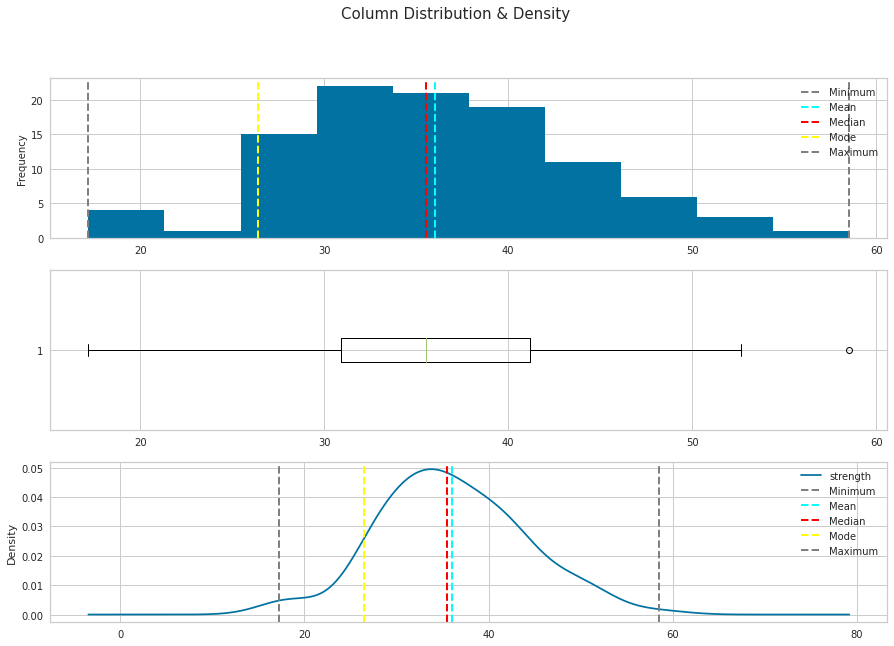

In [177]:
show_distribution_density(df['strength'])

In [178]:
outlier(df['strength'])

Num_Outliers: 1
Outliers    : [58.53]


- The target column contains 83 unique values.
- The mean and median values are very close to each other.
- It shows a distribution close to the normal distribution. 
- Although there seems to be 1 outlier on the Max side, it seems that there is no need to take any action for now.

###  'cement' column

In [179]:
summary('cement')

Column:  cement
****************************************************************************************************
Missing values:  0
****************************************************************************************************
Missing values(%):  0.0
****************************************************************************************************
Unique values:  80
****************************************************************************************************
Value counts: 
159.000    4
145.000    3
140.000    3
320.000    2
160.000    2
          ..
163.000    1
342.000    1
356.000    1
309.000    1
348.700    1
Name: cement, Length: 80, dtype: int64
****************************************************************************************************


Minimum:137.00
Mean:229.89
Median:248.00
Mode:159.00
Maximum:374.00



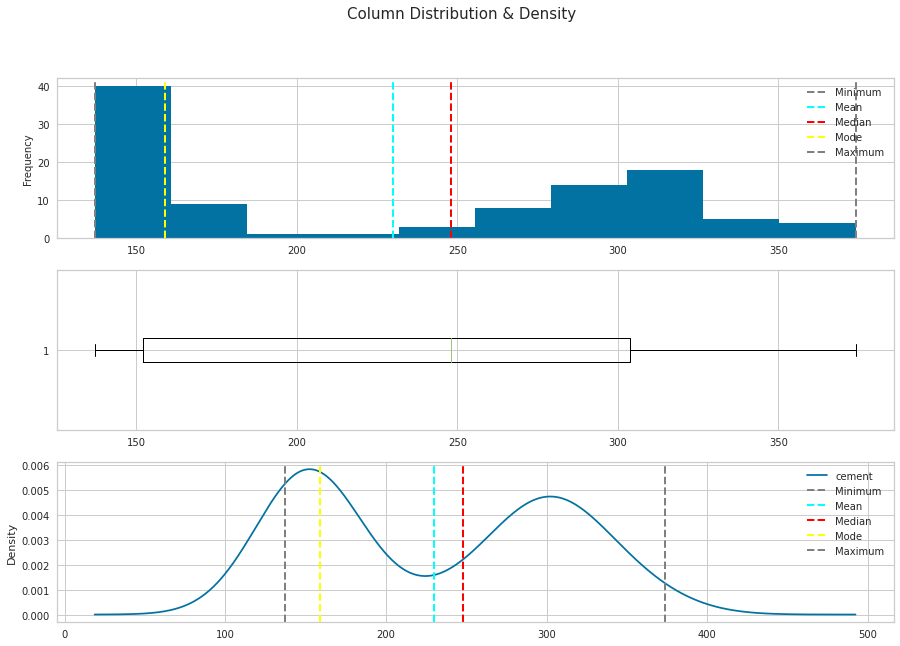

In [180]:
show_distribution_density(df['cement'])

In [181]:
outlier(df['cement'])

Num_Outliers: 0
Outliers    : []


- 'cement' column contains 80 unique values.
- The mean is to the left of the median, but still the values aren't that far apart.
- We have a non-symmetric distribution with 2 clear peaks, bimodal.

###  'slag' column

In [182]:
summary('slag')

Column:  slag
****************************************************************************************************
Missing values:  0
****************************************************************************************************
Missing values(%):  0.0
****************************************************************************************************
Unique values:  63
****************************************************************************************************
Value counts: 
0.000      26
106.000     5
107.000     3
148.000     2
112.000     2
           ..
149.000     1
110.000     1
124.000     1
131.000     1
0.100       1
Name: slag, Length: 63, dtype: int64
****************************************************************************************************


Minimum:0.00
Mean:77.97
Median:100.00
Mode:0.00
Maximum:193.00



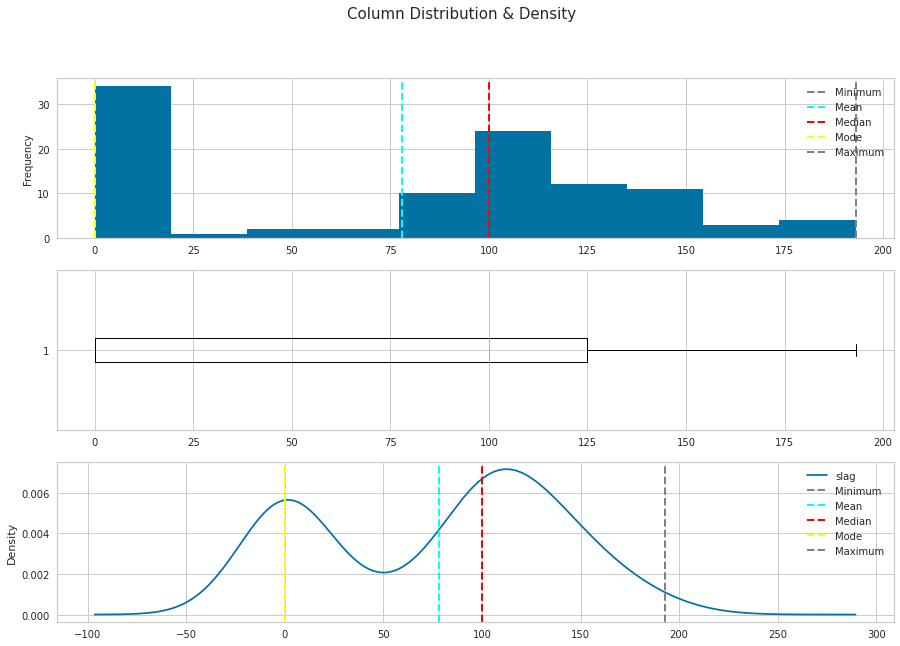

In [183]:
show_distribution_density(df['slag'])

In [184]:
outlier(df['slag'])

Num_Outliers: 0
Outliers    : []


- 'slag' column contains 63 unique values.
- The mean is to the left of the median, but still the values aren't that far apart.
- We have a non-symmetric distribution with 2 clear peaks, bimodal.

###  'fly_ash' column

In [185]:
summary('fly_ash')

Column:  fly_ash
****************************************************************************************************
Missing values:  0
****************************************************************************************************
Missing values(%):  0.0
****************************************************************************************************
Unique values:  58
****************************************************************************************************
Value counts: 
0.000      20
164.000     4
136.000     4
239.000     3
240.000     3
239.900     3
167.000     3
121.000     2
191.000     2
239.800     2
187.000     2
142.000     2
143.000     2
137.000     2
149.000     2
178.000     2
139.000     2
115.000     2
227.000     2
260.000     1
239.100     1
100.000     1
198.100     1
209.500     1
215.900     1
226.100     1
239.600     1
234.900     1
239.500     1
238.900     1
239.200     1
239.700     1
238.800     1
238.300     1
238.500     1
116.000     

Minimum:0.00
Mean:149.01
Median:164.00
Mode:0.00
Maximum:260.00



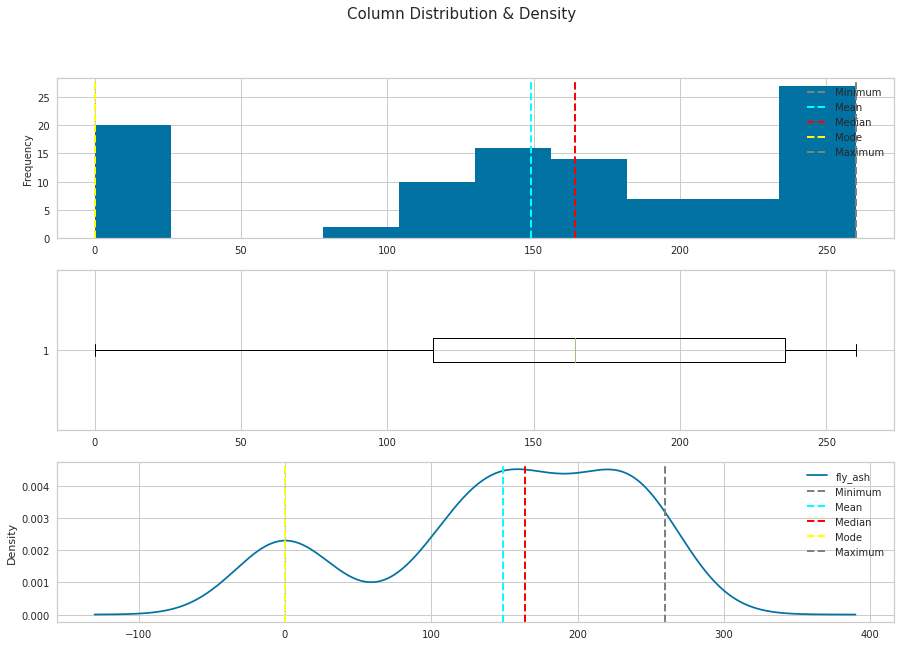

In [186]:
show_distribution_density(df['fly_ash'])

In [187]:
outlier(df['fly_ash'])

Num_Outliers: 0
Outliers    : []


- 'fly_ash' column contains 58 unique values.
- The mean is to the left of the median, but still the values aren't that far apart.
- We have a non-symmetric distribution with 2 peaks, bimodal.
- Although most of the values seem to be normally distributed, we can easily see that a group of values are separated on the left.

###  'water' column

In [188]:
summary('water')

Column:  water
****************************************************************************************************
Missing values:  0
****************************************************************************************************
Missing values(%):  0.0
****************************************************************************************************
Unique values:  70
****************************************************************************************************
Value counts: 
210.000    3
179.000    3
183.000    3
180.000    3
168.000    3
          ..
177.000    1
231.000    1
195.000    1
206.000    1
208.500    1
Name: water, Length: 70, dtype: int64
****************************************************************************************************


Minimum:160.00
Mean:197.17
Median:196.00
Mode:168.00
Maximum:240.00



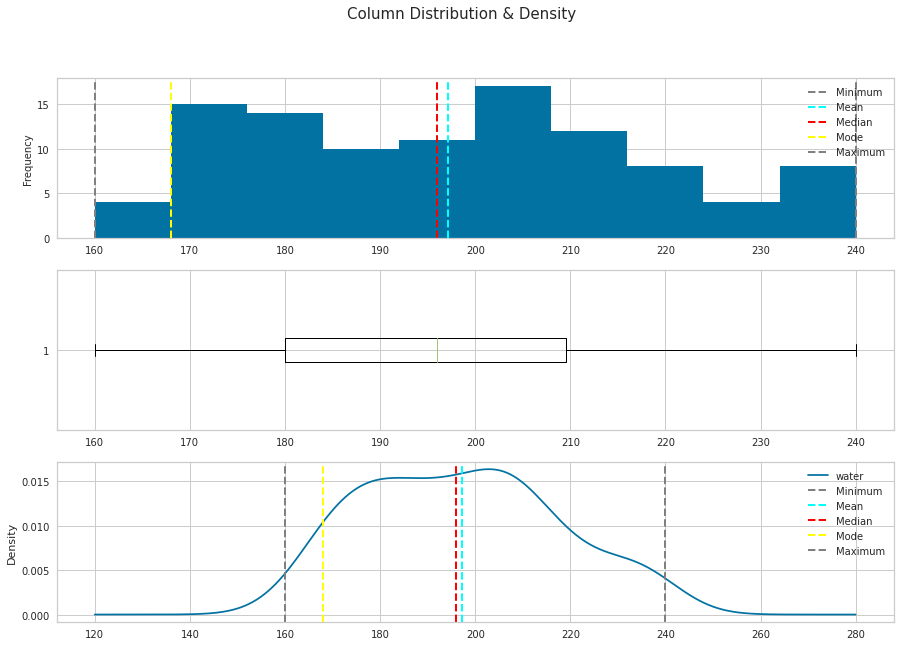

In [189]:
show_distribution_density(df['water'])

In [190]:
outlier(df['water'])

Num_Outliers: 0
Outliers    : []


- 'water' column contains 70 unique values.
- The mean and median values are very close to each other.
- It shows a distribution close to the normal distribution.

###  'sp' column

In [191]:
summary('sp')

Column:  sp
****************************************************************************************************
Missing values:  0
****************************************************************************************************
Missing values(%):  0.0
****************************************************************************************************
Unique values:  32
****************************************************************************************************
Value counts: 
6.000     24
11.000    12
10.000    11
9.000     11
12.000     6
7.000      5
7.400      3
7.700      2
7.500      2
8.300      2
13.000     2
8.000      2
6.500      2
7.600      1
5.700      1
7.100      1
6.700      1
8.900      1
6.200      1
4.900      1
5.500      1
5.300      1
9.200      1
4.700      1
4.600      1
4.400      1
5.000      1
15.000     1
18.000     1
19.000     1
16.000     1
9.600      1
Name: sp, dtype: int64
********************************************************************

Minimum:4.40
Mean:8.54
Median:8.00
Mode:6.00
Maximum:19.00



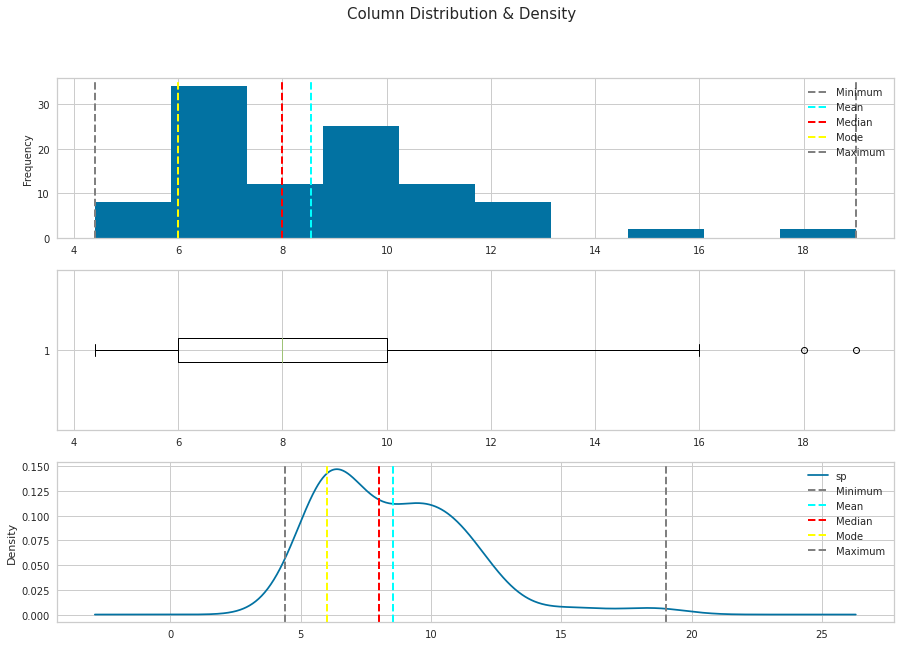

In [192]:
show_distribution_density(df['sp'])

In [193]:
outlier(df['sp'])

Num_Outliers: 2
Outliers    : [18.0, 19.0]


- 'sp' column contains 32 unique values.
- The mean and median values are very close to each other, but the mean is on the right side.
- The tail is slightly extended to the right, right-skewed.

###  'coarse' column

In [194]:
summary('coarse')

Column:  coarse
****************************************************************************************************
Missing values:  0
****************************************************************************************************
Missing values(%):  0.0
****************************************************************************************************
Unique values:  92
****************************************************************************************************
Value counts: 
904.000    3
750.000    2
871.000    2
883.000    2
959.000    2
          ..
835.000    1
810.000    1
708.000    1
759.000    1
786.200    1
Name: coarse, Length: 92, dtype: int64
****************************************************************************************************


Minimum:708.00
Mean:883.98
Median:879.00
Mode:904.00
Maximum:1049.90



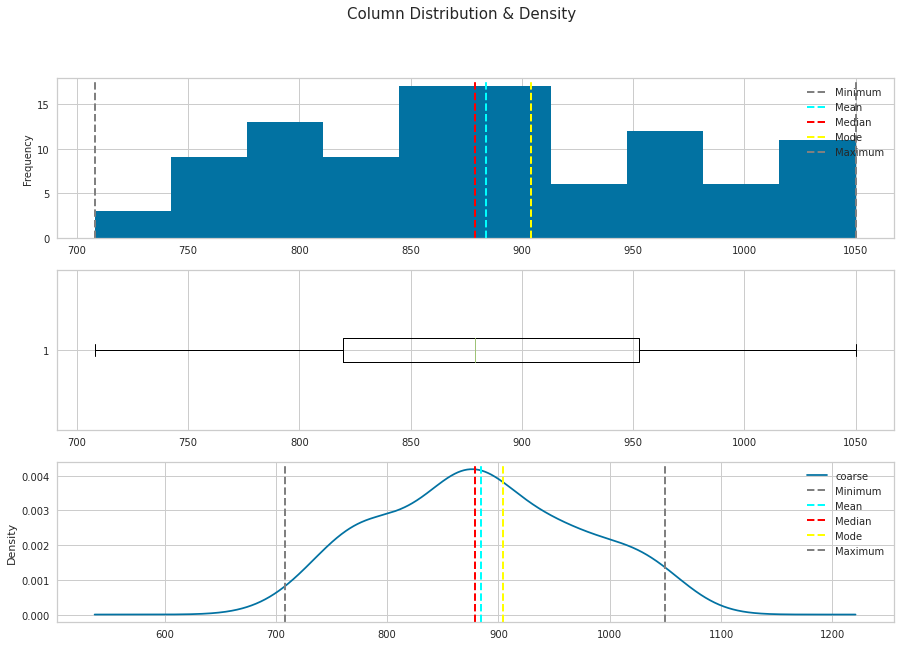

In [195]:
show_distribution_density(df['coarse'])

In [196]:
outlier(df['coarse'])

Num_Outliers: 0
Outliers    : []


- 'coarse' column contains 92 unique values.
- The mean and median values are very close to each other.
- It shows a distribution close to the normal distribution.

###  'fine' column

In [197]:
summary('fine')

Column:  fine
****************************************************************************************************
Missing values:  0
****************************************************************************************************
Missing values(%):  0.0
****************************************************************************************************
Unique values:  90
****************************************************************************************************
Value counts: 
757.000    4
680.000    2
644.100    2
778.000    2
827.000    2
          ..
721.000    1
774.000    1
655.000    1
650.000    1
758.100    1
Name: fine, Length: 90, dtype: int64
****************************************************************************************************


Minimum:640.60
Mean:739.60
Median:742.70
Mode:757.00
Maximum:902.00



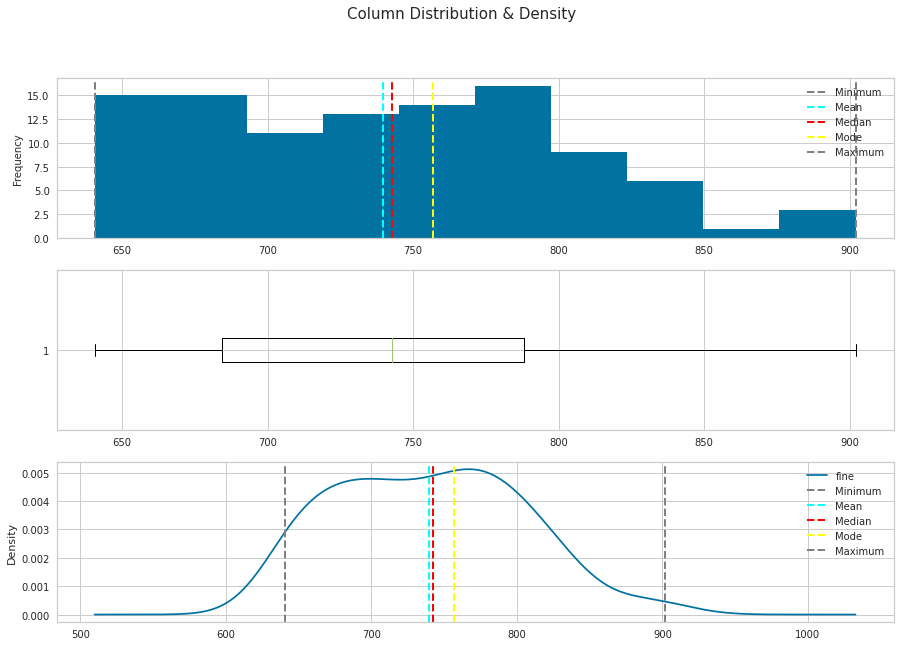

In [198]:
show_distribution_density(df['fine'])

In [199]:
outlier(df['fine'])

Num_Outliers: 0
Outliers    : []


- 'fine' column contains 90 unique values.
- The mean and median values are very close to each other.
- It shows a distribution close to the normal distribution.

###  'slump' column

In [200]:
summary('slump')

Column:  slump
****************************************************************************************************
Missing values:  0
****************************************************************************************************
Missing values(%):  0.0
****************************************************************************************************
Unique values:  39
****************************************************************************************************
Value counts: 
0.000     11
23.000     8
25.000     8
24.000     7
21.000     5
14.500     5
23.500     5
25.500     3
27.500     3
26.500     3
24.500     3
19.000     3
20.000     3
23.750     2
21.500     2
2.000      2
22.000     2
17.000     2
3.000      2
20.500     2
18.000     2
13.000     2
12.000     2
15.500     1
9.500      1
21.250     1
16.250     1
26.000     1
27.000     1
22.500     1
8.000      1
16.000     1
17.500     1
2.500      1
1.000      1
25.750     1
15.000     1
24.750     1
29.000    

Minimum:0.00
Mean:18.05
Median:21.50
Mode:0.00
Maximum:29.00



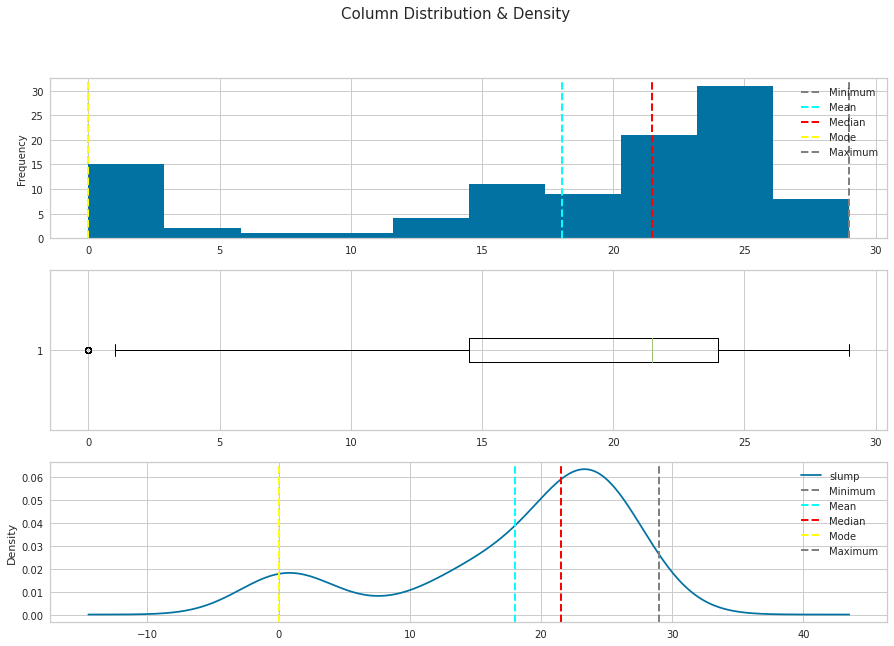

In [201]:
show_distribution_density(df['slump'])

In [202]:
outlier(df['slump'])

Num_Outliers: 11
Outliers    : [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


- 'slump' column contains 39 unique values.
- The mean and median values are close to each other, but the mean is on the left side.
- The tail is slightly extended to the left, left-skewed.

###  'flow' column

In [203]:
summary('flow')

Column:  flow
****************************************************************************************************
Missing values:  0
****************************************************************************************************
Missing values(%):  0.0
****************************************************************************************************
Unique values:  51
****************************************************************************************************
Value counts: 
20.000    17
64.000     6
67.000     4
60.000     4
46.000     3
48.000     3
51.000     3
61.000     3
54.000     3
70.000     3
78.000     3
62.000     2
69.000     2
65.000     2
57.000     2
53.000     2
49.000     2
58.000     2
68.500     2
55.000     2
58.500     2
48.500     2
50.000     1
27.000     1
63.000     1
47.000     1
39.000     1
63.500     1
41.500     1
31.000     1
75.000     1
36.500     1
52.500     1
27.500     1
40.000     1
64.500     1
61.500     1
30.000     1
42.000     

Minimum:20.00
Mean:49.61
Median:54.00
Mode:20.00
Maximum:78.00



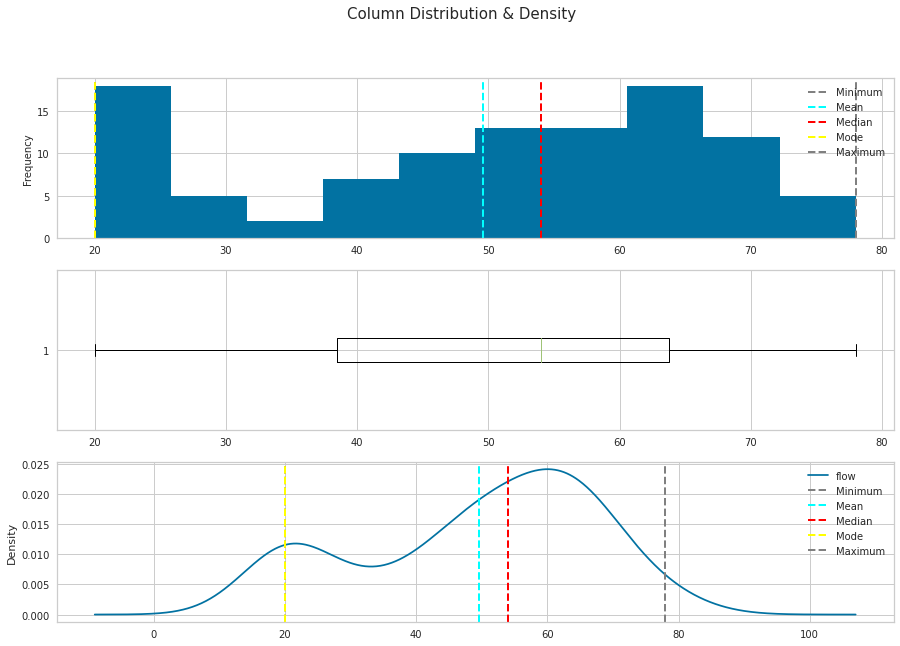

In [204]:
show_distribution_density(df['flow'])

In [205]:
outlier(df['flow'])

Num_Outliers: 0
Outliers    : []


- 'flow' column contains 39 unique values.
- The mean and median values are close to each other, but the mean is on the left side.
- The tail is slightly extended to the left, left-skewed.

## 5.3 Relationship Between Target and Features

Now that we know something about the distribution of the data in our columns, we can start to look for relationships between the features and the target we want to be able to predict. 

### 5.3.1 HistPlot and Probability Plot

In [206]:
def check_dist(df, var):
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    sns.histplot(x=var, data=df)
    plt.subplot(1, 2, 2)
    stats.probplot(df[var], dist="norm", plot=plt)
    plt.show()

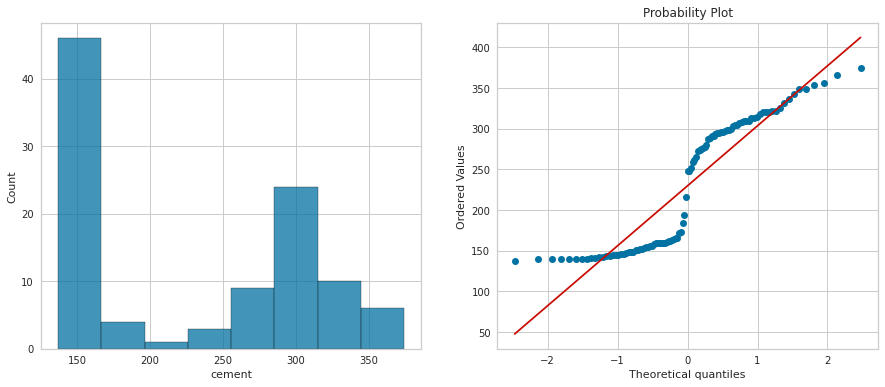

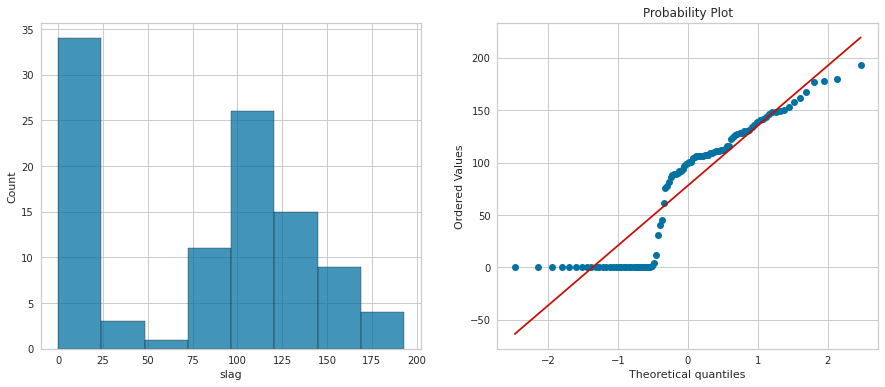

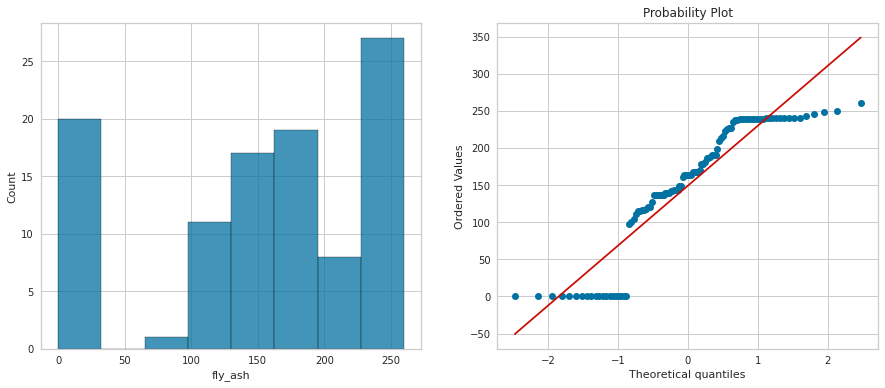

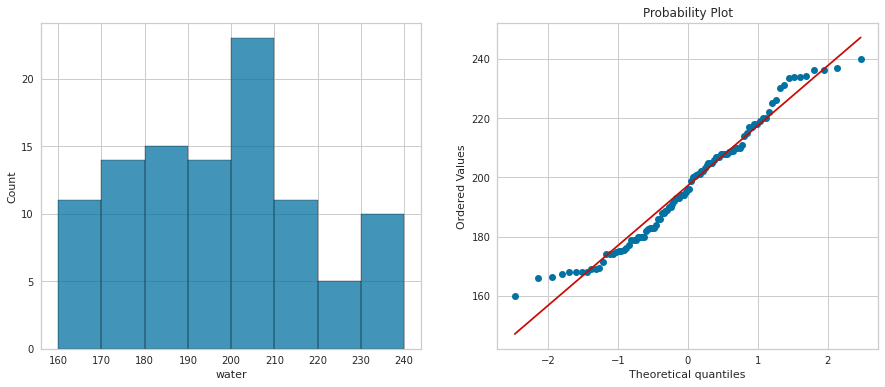

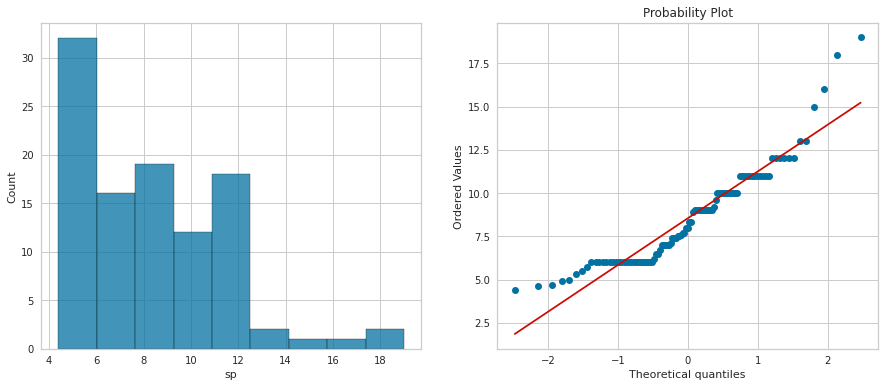

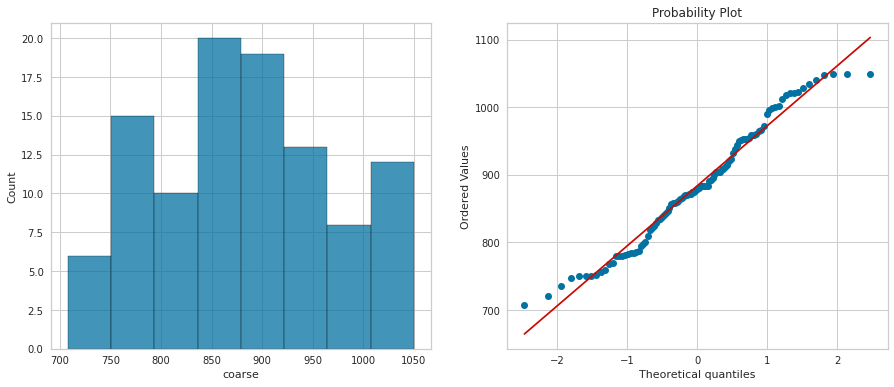

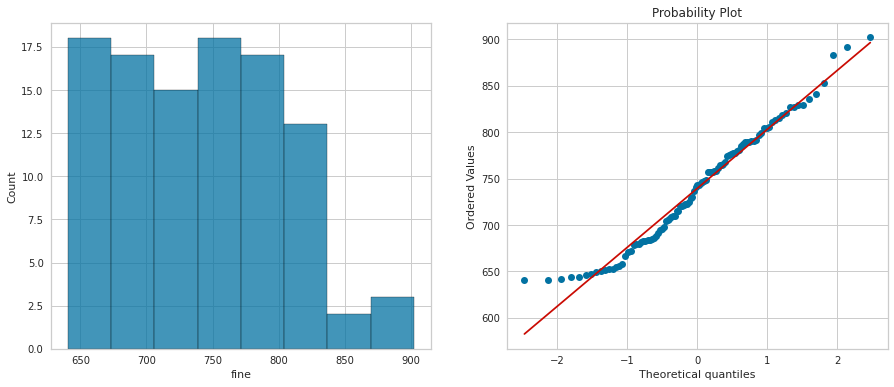

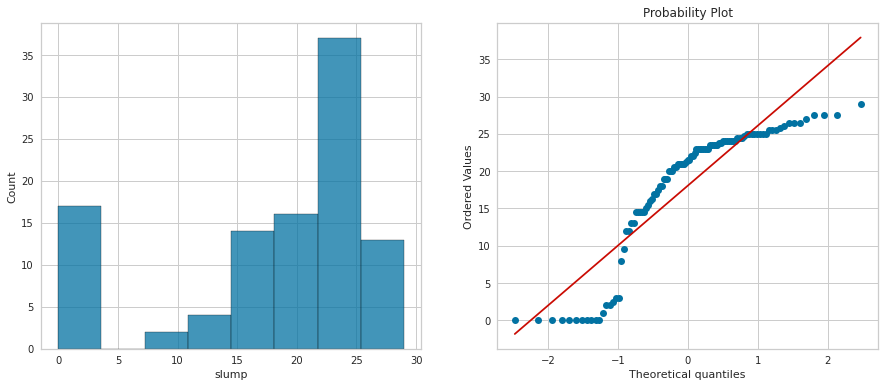

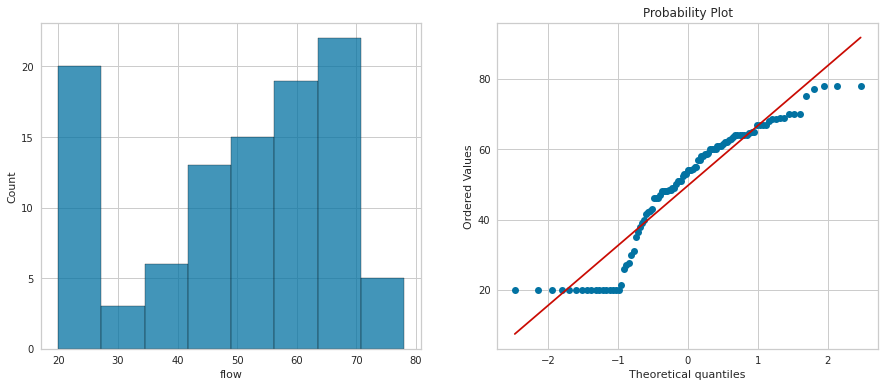

In [207]:
for col in df.drop("strength", axis=1).columns:
    check_dist(df, col)

- If my values are wrapped around the regression line like a ivy, we can say that there is a normal distribution here.
- But if there is deviation (away from the line) on one side, it means that it has moved away from the normal distribution.

### 5.3.2 Scatter Plot

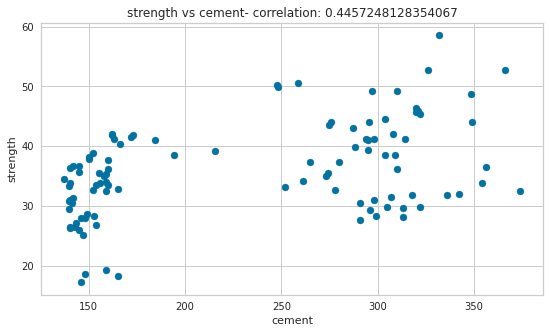

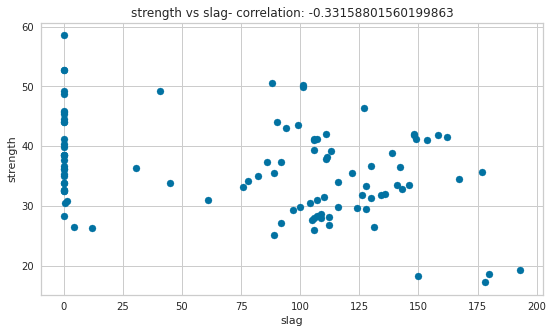

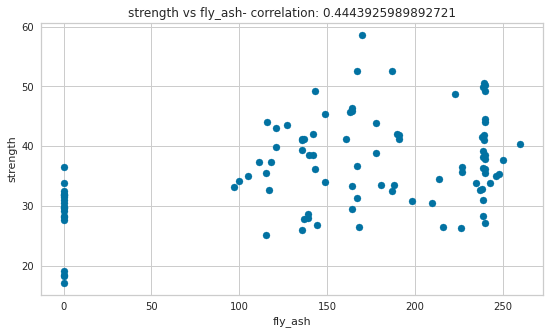

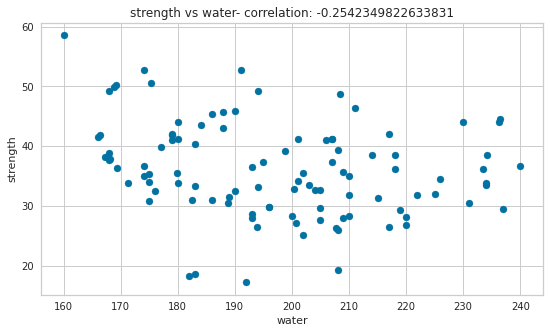

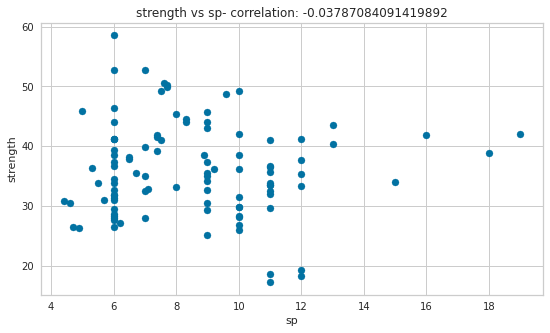

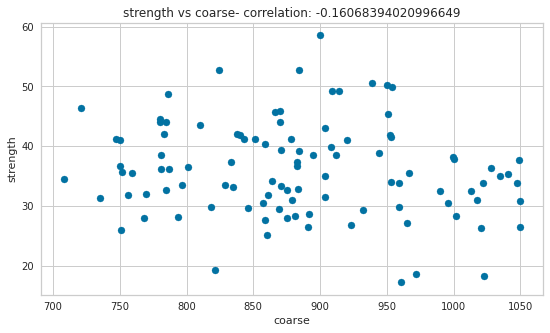

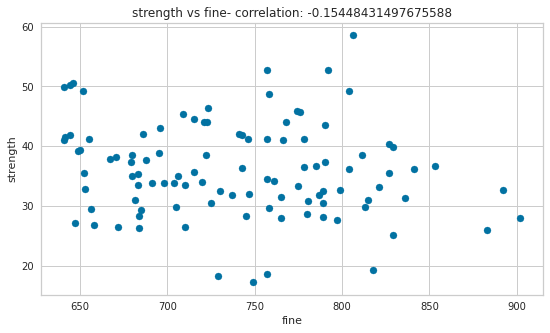

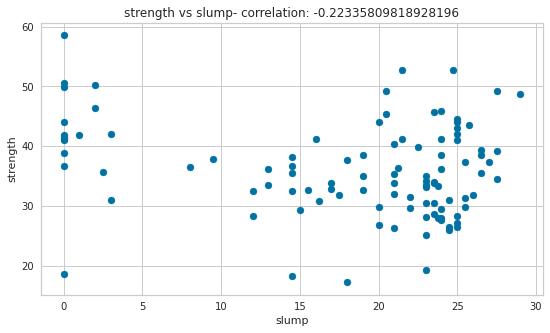

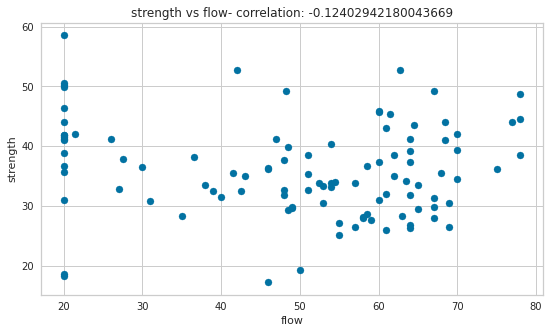

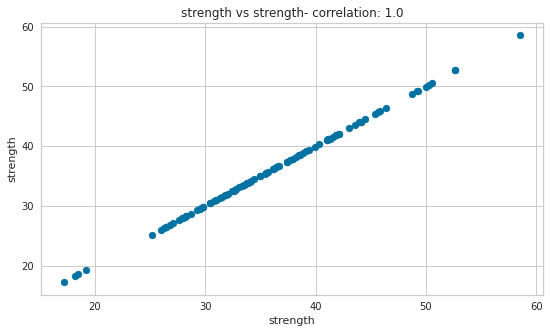

In [208]:
for col in df.columns:
    fig = plt.figure(figsize=(9, 5))
    ax = fig.gca()
    feature = df[col]
    label = df['strength']
    correlation = feature.corr(label)
    plt.scatter(x=feature, y=label)
    plt.xlabel(col)
    plt.ylabel('strength')
    ax.set_title('strength vs ' + col + '- correlation: ' + str(correlation))
plt.show()

### 5.3.3 PairPlot

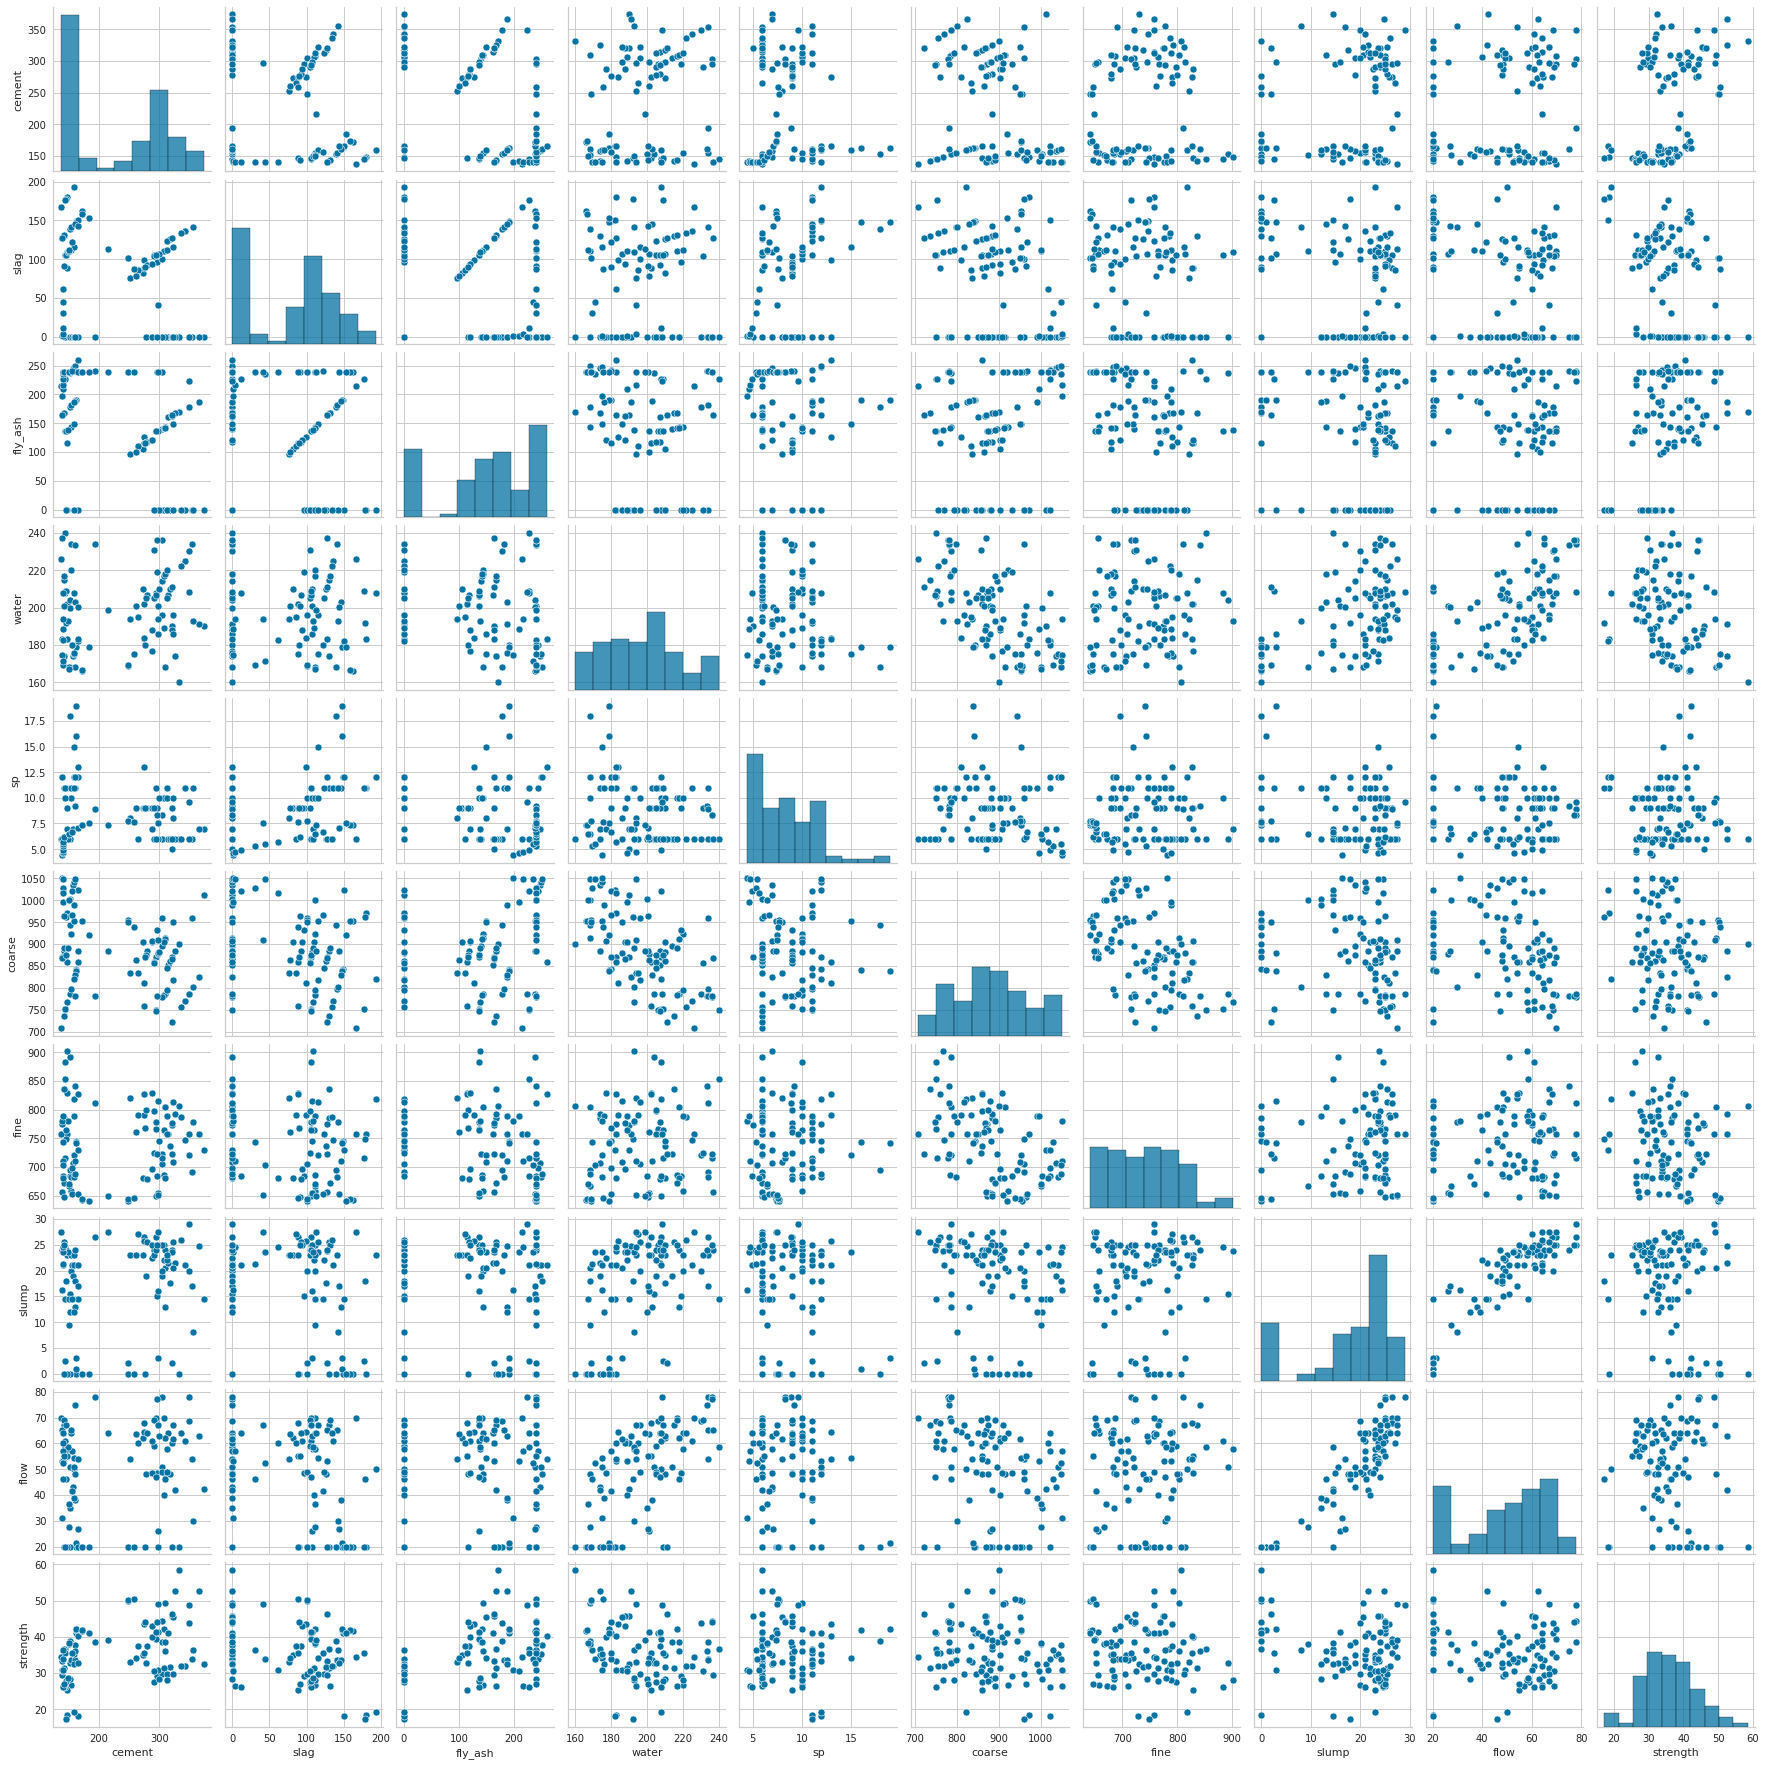

In [209]:
sns.pairplot(df);

### 5.3.4 Correlation

We look at the correlation values of all features with target/label. Although the strength of the relationship between them gives us an idea of which features are more important in predicting, we cannot decide this with correlation alone.

Correlation tells me whether we can talk about a linearity or not.

In [210]:
corr_by_target = df.corr()[target].sort_values()
corr_by_target

slag       -0.332
water      -0.254
slump      -0.223
coarse     -0.161
fine       -0.154
flow       -0.124
sp         -0.038
fly_ash     0.444
cement      0.446
strength    1.000
Name: strength, dtype: float64

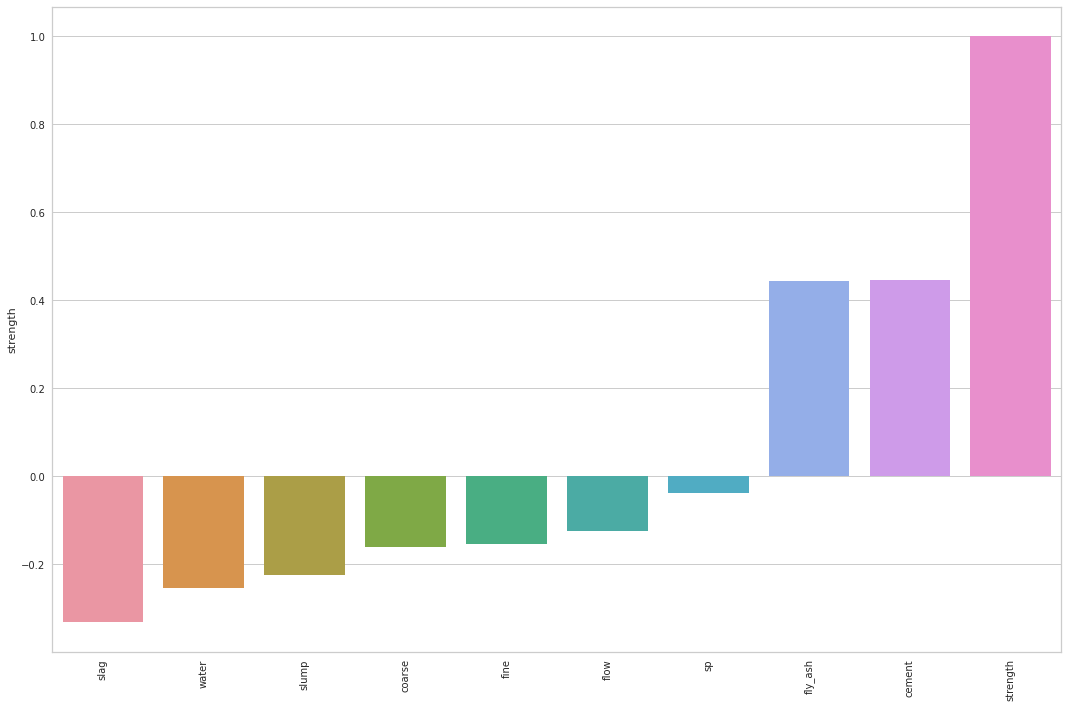

In [211]:
plt.figure(figsize = (15,10))
sns.barplot(x = corr_by_target.index, y = corr_by_target)
plt.xticks(rotation=90)
plt.tight_layout();

When the distribution seen on the scatter plot and correlation values are evaluated together,
- 'cement' and 'fly_ash' columns are positively correlated with target column.
- 'slag', 'water', 'sp', 'coarse', 'fine', 'slump' and 'flow' columns are negatively correlated with target column.
- When looking at scatter plots, there is weak linearity between the target and other columns except cement, slag and fly_ash.

## 5.4 Multicollinearity Control

If there is a strong correlation between the independent variables, this situation is called **multicolineraty**.
 
**Multicolineraty** prevents my model from detecting important features.

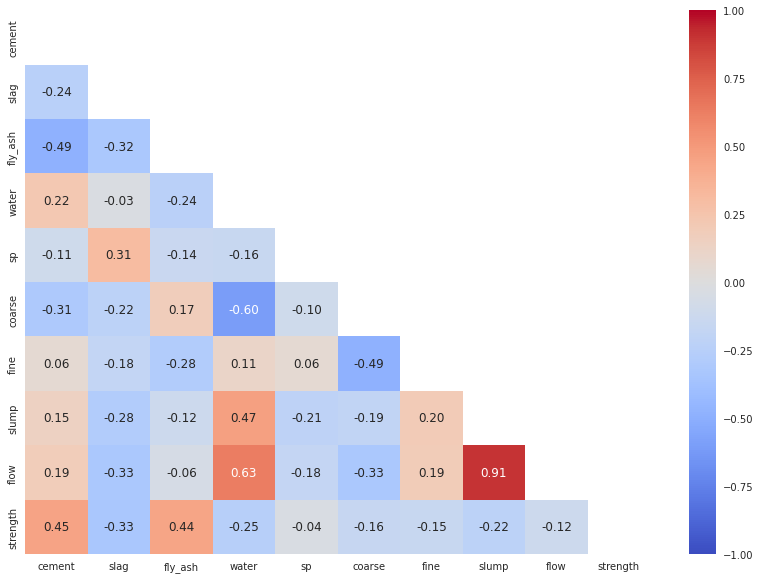

In [212]:
matrix = np.triu(df.corr())
fig, ax = plt.subplots(figsize=(14,10)) 
sns.heatmap (df.corr(), annot=True, fmt= '.2f', vmin=-1, vmax=1, center=0, cmap='coolwarm',mask=matrix, ax=ax);

In [213]:
multicolinearity_control(df)

Multicolinearity alert in between --> slump - flow --> 0.906135
Multicolinearity alert in between --> flow - slump --> 0.906135


There is multicollinearity between columns 'slump' and 'flow'.

The problem of multicollinearity can be overcome by several different methods. However, each method has its own cons and prons. To get the best trade off in terms of cons and pros, you need domain knowledge and a good understanding of the problem at hand.

To overcome multicollinearity;

- Remove some of the highly correlated independent variables,

- Linearly combine the independent variables, such as adding them together,

- Perform an analysis designed for highly correlated variables, such as principal components analysis or partial least squares regression.

- Use regularization models like Lasso and Ridge. 

## 5.5 Handling with Skewness

Skewed data is common in data science; skew is the degree of distortion from a normal distribution.
Generally, if the shape is;
- Perfectly symmetric, the mean equals the median,
- Skewed to the right, the mean is larger than the median,
- Skewed to the left, the mean is smaller than the median.

In [214]:
skew_limit = 0.75 
skew_vals = df.skew()
skew_cols = skew_vals[abs(skew_vals)> skew_limit].sort_values(ascending=False)
skew_cols 

sp       1.126
slump   -1.113
dtype: float64

- The acceptable range of skewness is between -1 and +1 for appling linear regression.
- If my skew value is between -0.5 and +0.5 we can talk about normal distribution, therefore suitable for linear regression.
- Between 0.5 and 1, we can say that there is moderate (moderate) skewness. In this case, we can use linear regression.
- But skewness is greater or smaller than -/+ 1 we cannot implement implement linear regression.
- This is our threshold-limit to evaluate skewness. Overall below abs(1) seems acceptable for the linear models. 

**With np.log**

In [215]:
df_log = df[skew_cols.index].copy()

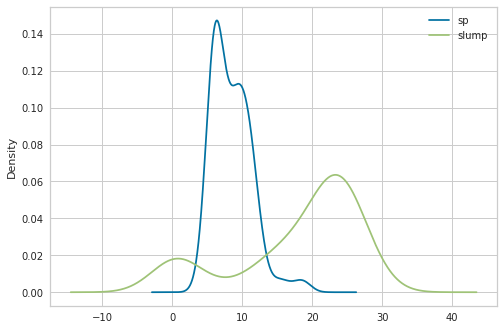

In [216]:
for col in df_log.columns:
    df_log[col].plot.density()
    plt.legend(loc='upper right')   

In [217]:
for col in skew_cols.index.values:
    df_log[col] = df_log[col].apply(np.log1p)
print(df_log[skew_cols.index].skew())

sp       0.371
slump   -1.847
dtype: float64


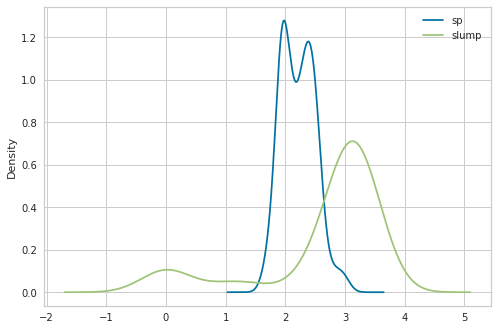

In [218]:
for col in df_log.columns:
    df_log[col].plot.density()
    plt.legend(loc='upper right') 

**With Power Transformer**

In [219]:
df_trans = df[skew_cols.index].copy()

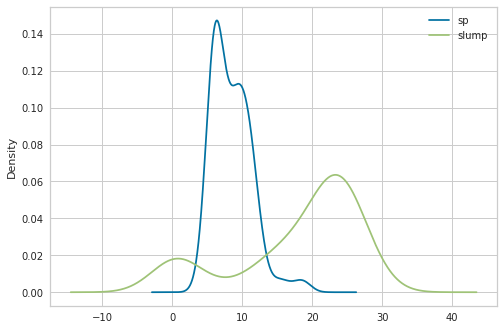

In [220]:
for col in df_trans.columns:
    df_trans[col].plot.density()
    plt.legend(loc='upper right') 

In [221]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='yeo-johnson')
trans= pt.fit_transform(df_trans)
df_trans = pd.DataFrame(trans, columns =skew_cols.index)
print(df_trans.skew())

sp       0.040
slump   -0.877
dtype: float64


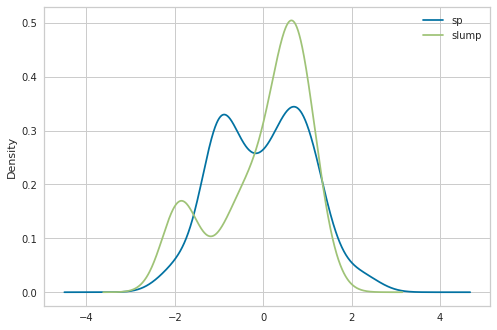

In [222]:
for col in df_trans.columns:
    df_trans[col].plot.density()
    plt.legend(loc='upper right') 

Compared to np.log, it is seen that the results obtained with power_transformers are better.

In [223]:
df.columns

Index(['cement', 'slag', 'fly_ash', 'water', 'sp', 'coarse', 'fine', 'slump',
       'flow', 'strength'],
      dtype='object')

In [224]:
df_trans.columns

Index(['sp', 'slump'], dtype='object')

In [225]:
df.drop(['sp', 'slump'], axis=1, inplace=True)
df = pd.concat([df, df_trans], axis=1)
df.columns

Index(['cement', 'slag', 'fly_ash', 'water', 'coarse', 'fine', 'flow',
       'strength', 'sp', 'slump'],
      dtype='object')

In [226]:
last_column = df.pop('strength')
df.insert(9, 'strength', last_column)
df.head(1)

,cement,slag,fly_ash,water,coarse,fine,flow,sp,slump,strength
0,273.000,82.000,105.000,210.000,904.000,680.000,62.000,0.390,0.565,34.990


In [227]:
skew_limit = 0.75
skew_vals = df.skew()
skew_cols= skew_vals[abs(skew_vals)> skew_limit].sort_values(ascending=False)
skew_cols

slump   -0.877
dtype: float64

# 6. Data Preprocessing 

While starting we should import the necessary modules. I usually import the relevant libraries and modules in my own work at the beginning. Here, I will import the relevant libraries and modules step by step in order to have a beginner friendly work and to increase the memorability for all of us.

We'll need to do a few pre-processing before moving to modelling. After that we will implement Linear Regression, Ridge Regression, Lasso Regression,and Elastic-Net algorithms respectively.

## 6.1 Features and target variable

As you know, the data set must be edited before proceeding to the implementation of the model. We must drop the target variable, the column we are trying to predict.

In [228]:
X = df.drop('strength', axis=1)
y = df['strength']

In [229]:
print ('X shape : %d rows\ny shape : %d rows' % (X.shape[0], y.shape[0]))

X shape : 103 rows
y shape : 103 rows


## 6.2 Splitting data into training and testing

As the last step before model fitting, we need to split the data set as train and test. Then, we should train the model with train data and evaluate the performance of the model on the test data. We can use the train and test data we have created for all algorithms.

In [230]:
from sklearn.model_selection import train_test_split

In [231]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [232]:
print ('Training Set: %d rows\nTest Set    : %d rows' % (X_train.shape[0], X_test.shape[0]))

Training Set: 82 rows
Test Set    : 21 rows


## 6.3 Scaling

Scaling is, in basic terms, to fit our data to the same ranges.

The ranges of my features can have different range values for each. If we don't do a scale, features in a large range are weighted more (valid for distance-based models) and our model will return incorrect results. We use scale to prevent this. It also accelerates the work of Gradient descent-based models such as linear, logistic regression and accurately detects which featurs are important.

There is no disadvantage of applying scale to data. data scale If you are confused about whether to apply it or not, you can apply scale directly.

In [233]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [234]:
for col in df.columns:
    print(f'{col} range :', round(np.min(df[col]),2), "-", round(np.max(df[col]),2))

cement range : 137.0 - 374.0
slag range : 0.0 - 193.0
fly_ash range : 0.0 - 260.0
water range : 160.0 - 240.0
coarse range : 708.0 - 1049.9
fine range : 640.6 - 902.0
flow range : 20.0 - 78.0
sp range : -2.2 - 2.39
slump range : -1.93 - 1.45
strength range : 17.19 - 58.53


In [235]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train) 
X_test_scaled = scaler.transform(X_test)

In [236]:
X_train_scaled[1]

array([-1.04096079,  1.65777393, -1.64936204, -0.65655824,  0.95172686,
        0.28924939, -1.59112335,  0.9964597 , -1.83206239])

In [237]:
X_test_scaled[1]

array([-0.81306726, -1.29720985,  1.30473577, -0.65655824, -0.33492343,
        1.41509971,  0.3154619 ,  1.45761468,  0.32038752])

#  7. Linear Regression

## 7.1 Model Building

 - Import the modul
 - Fit the model 
 - Predict the test set
 - Determine feature coefficiant
 - Evaluate model performance (use performance metrics for regression and cross_val_score)
 - Compare different evaluation metrics

In [238]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

There are many metrics used specifically for regression. Frequently used ones are the the ones imported above.

LinearRegression() 

      linear_train  linear_test
R2           0.905        0.908
mae          1.958        1.752
mse          6.029        4.640
rmse         2.455        2.154


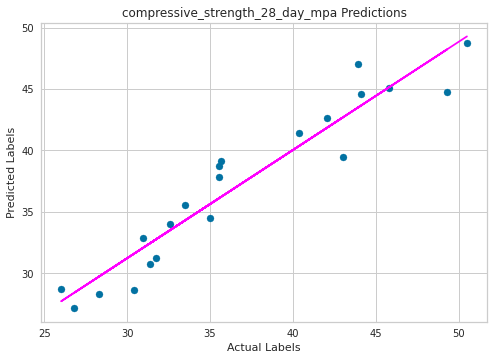

In [239]:
# Fit Linear model on the training set. The model is trained on x_train and y_train.
linear = LinearRegression().fit(X_train_scaled, y_train)
print (linear, "\n")

# Evaluate the model using the test data. The trained model is run on X_test and metrics are retrieved.
y_pred = linear.predict(X_test_scaled)
y_train_pred = linear.predict(X_train_scaled)
ls =train_val(y_train, y_train_pred, y_test, y_pred, "linear")
print(ls)

# Plot predicted vs actual
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('compressive_strength_28_day_mpa Predictions')

# Overlay the regression line
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

y_pred = linear.predict(X_test_scaled)
linear_R2 = r2_score(y_test, y_pred)
linear_mae = mean_absolute_error(y_test, y_pred)
linear_mse = mean_squared_error(y_test, y_pred)
linear_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

If there is a difference between TRAIN and TEST scores;
- First we need to do cross validation. We should evaluate TRAIN and TEST scores accordingly.
- Then we should try to approximate the TEST score to the TRAIN score by playing with the hyperparameters.
- As a result of this approximation, we should evaluate the scores.

## 7.2 Adjusted R2 Score

In [240]:
def adj_r2(y_test, y_pred, X):
    r2 = r2_score(y_test, y_pred)
    n = X.shape[0]   # number of observations
    p = X.shape[1]   # number of independent variables 
    adj_r2 = 1 - (1-r2)*(n-1)/(n-p-1)
    return adj_r2

In [241]:
adj_r2(y_test, y_pred, X)

0.8994210938181755

## 7.3 Cross Validation

We do cross-validation to check whether the one-time scores we receive are consistent or not, in other words to measure the estimator performance. Cross validation is only applied to the train set.

Cross validation uses different data samples from train set and calculates scores for each data sample. We can calculate the final performance of estimator by averaging these scores.

For the better results, we should try to increase the success of the models by performing hyperparameter tuning. Determine feature importances for the model. We can set our model with the most important features for resource saving.

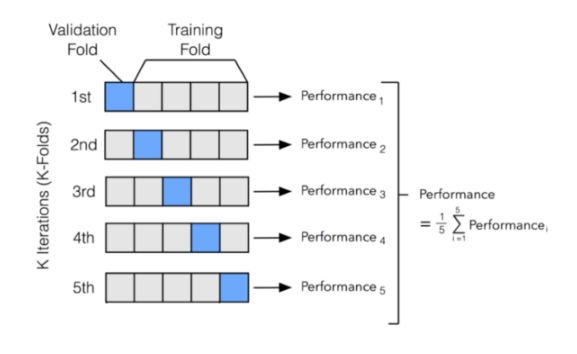

In [242]:
from sklearn.model_selection import cross_validate, cross_val_score 
from sklearn.metrics import SCORERS

In [243]:
linear = LinearRegression()
scores = cross_validate(linear, X_train_scaled, y_train, scoring = ['r2', 'neg_mean_absolute_error','neg_mean_squared_error', \
                                                            'neg_root_mean_squared_error'], cv = 10)

scores = pd.DataFrame(scores, index=range(1,11))
scores.iloc[:, 2:].mean()

test_r2                             0.821
test_neg_mean_absolute_error       -2.252
test_neg_mean_squared_error        -8.048
test_neg_root_mean_squared_error   -2.739
dtype: float64

In [244]:
print(ls)

      linear_train  linear_test
R2           0.905        0.908
mae          1.958        1.752
mse          6.029        4.640
rmse         2.455        2.154


## 7.4 Model Evaluation

### 7.4.1 Prediction Error

In [245]:
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error, mean_squared_error

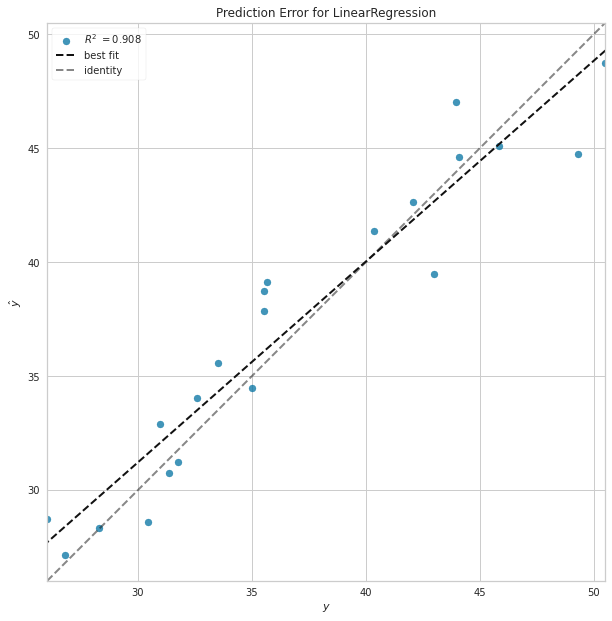

In [246]:
from yellowbrick.regressor import PredictionError
from yellowbrick.features import RadViz

visualizer = RadViz(size=(720, 3000))
model = LinearRegression()
visualizer = PredictionError(model)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show();

### 7.4.2 Residuals Plot

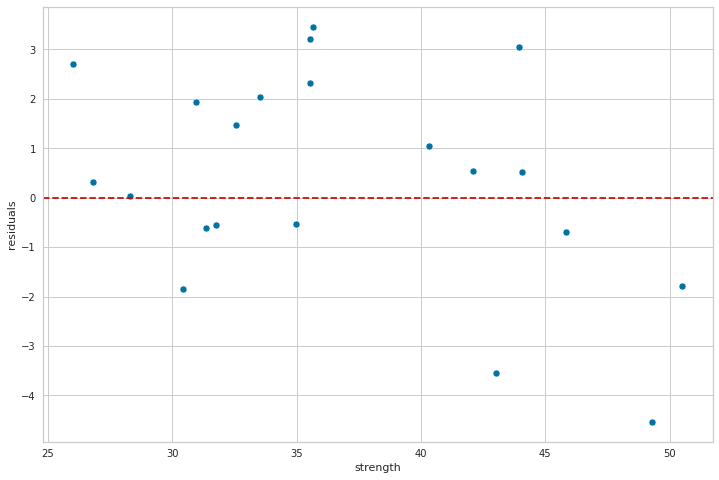

In [247]:
plt.figure(figsize=(12,8))
residuals = y_test-y_pred

sns.scatterplot(x = y_test, y = -residuals) #-residuals
plt.axhline(y = 0, color ="r", linestyle = "--")
plt.ylabel("residuals")
plt.show()

In [248]:
from scipy.stats import skew
skew(residuals)

0.5624763508848234

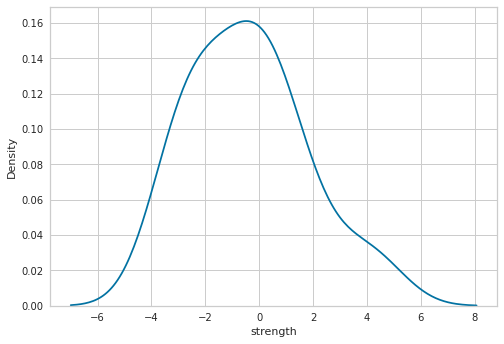

In [249]:
sns.kdeplot(residuals);

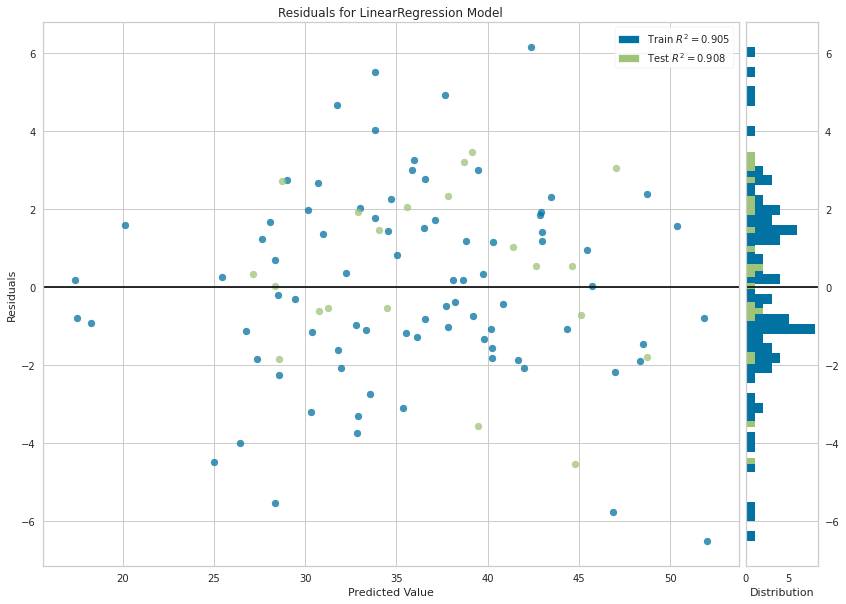

In [250]:
from yellowbrick.regressor import ResidualsPlot

visualizer = RadViz(size=(1000, 720))
model = LinearRegression()
visualizer = ResidualsPlot(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show();   

     Actual   Pred  Residual
90   35.520 37.845    -2.325
0    34.990 34.459     0.531
97   44.080 44.610    -0.530
45   31.770 31.226     0.544
42   33.510 35.557    -2.047
4    26.820 27.147    -0.327
26   42.080 42.625    -0.545
18   49.300 44.760     4.540
79   30.430 28.591     1.839
30   45.820 45.117     0.703
31   43.950 47.009    -3.059
33   35.520 38.727    -3.207
12   31.370 30.756     0.614
85   30.970 32.903    -1.933
62   28.290 28.327    -0.037
40   35.660 39.121    -3.461
47   43.010 39.460     3.550
100  50.500 48.720     1.780
10   26.020 28.731    -2.711
76   32.570 34.039    -1.469


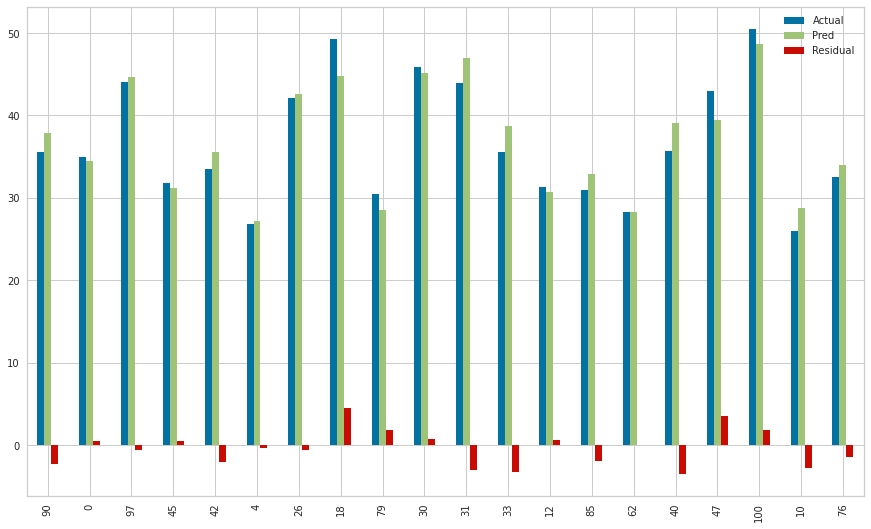

In [251]:
my_dict = { 'Actual': y_test, 'Pred': y_pred, 'Residual': y_test-y_pred }
compare = pd.DataFrame(my_dict)

comp_sample = compare.sample(20)
print(comp_sample)

comp_sample.plot(kind='bar',figsize=(15,9))
plt.show()

## 7.5 Feature Importance

In [252]:
model.coef_

array([ 0.04868908, -0.04266773,  0.03922896, -0.25892104, -0.06856833,
       -0.04990283,  0.08692135, -0.07864035, -2.10377054])

In [253]:
LM_feature_imp = pd.DataFrame(model.coef_, index = X.columns, columns=["Coef"]).sort_values("Coef")
LM_feature_imp

,Coef
slump,-2.104
water,-0.259
sp,-0.079
coarse,-0.069
fine,-0.050
slag,-0.043
fly_ash,0.039
cement,0.049
flow,0.087


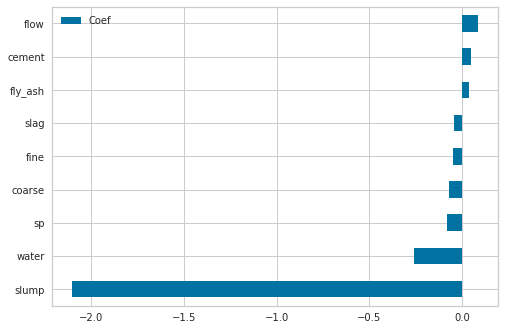

In [254]:
LM_feature_imp.plot(kind='barh');

# 8. Regularization

In linear regression, if there is a correlation between independent variables, **multicollinearity** occurs. With this problem, the estimates may be **unstable**, there may be different signs and estimates for the model parameters than they should be, *the parameter variances may be larger** than they are, very small changes in the data may show huge differentations in the parameters.

This situation creates the need for **regularization**.

Regularization tries to adjust the parameters in the target function, hoping to make the model less sensitive to fluctuations. 
Regularization adds an extra **alpha** value to **cost function**, which is used only to evaluate the model. The alpha value checks the cost function parameters and makes sure they don't get excessive values. Regularization usually leads to an increase in **bias**, but significantly reduces **variance**.

## 8.1 Ridge

The main idea behind **Ridge Regression** is to find a **New Line** that does not fit **Traing Data** as well. In other words, we introduce a small amount of **Bias** into how the New Line is fit to the data. By starting with a slightly worse fit, Ridge Regression can provide better long term prediction.

### 8.1.1 Ridge Modelling

- Import the modul 
- Do not forget to scale the data or use Normalize parameter as True 
- Fit the model 
- Predict the test set 
- Evaluate model performance (use performance metrics for regression) 
- Tune alpha hiperparameter by using [cross validation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html) and determine the optimal alpha value.
- Fit the model and predict again with the new alpha value. 

In [255]:
from sklearn.linear_model import Ridge

Ridge() 

      ridge_train  ridge_test
R2          0.904       0.908
mae         1.964       1.750
mse         6.101       4.630
rmse        2.470       2.152


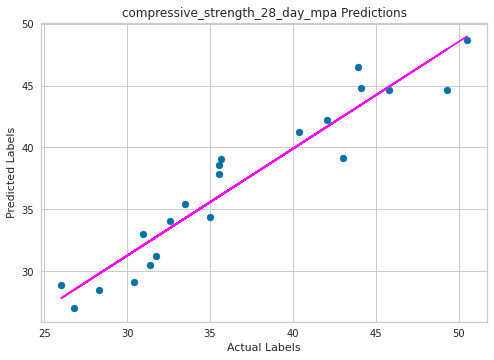

In [256]:
# Fit Ridge model on the training set
ridge = Ridge().fit(X_train_scaled, y_train)
print (ridge, "\n")

# Evaluate the model using the test data
y_pred = ridge.predict(X_test_scaled)
y_train_pred = ridge.predict(X_train_scaled)
rs =train_val(y_train, y_train_pred, y_test, y_pred, "ridge")
print(rs)

# Plot predicted vs actual
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('compressive_strength_28_day_mpa Predictions')

# Overlay the regression line
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

y_pred = ridge.predict(X_test_scaled)
ridge_R2 = r2_score(y_test, y_pred)
ridge_mae = mean_absolute_error(y_test, y_pred)
ridge_mse = mean_squared_error(y_test, y_pred)
ridge_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

### 8.1.2 Cross Validation

In [257]:
ridge = Ridge()
scores = cross_validate(ridge, X_train_scaled, y_train, scoring = ['r2', 'neg_mean_absolute_error','neg_mean_squared_error', \
                                                            'neg_root_mean_squared_error'], cv = 10)

scores = pd.DataFrame(scores, index=range(1,11))
scores.iloc[:, 2:].mean()

test_r2                             0.823
test_neg_mean_absolute_error       -2.241
test_neg_mean_squared_error        -8.019
test_neg_root_mean_squared_error   -2.726
dtype: float64

In [258]:
print(rs)

      ridge_train  ridge_test
R2          0.904       0.908
mae         1.964       1.750
mse         6.101       4.630
rmse        2.470       2.152


### 8.1.3 GridSearch

In [259]:
from sklearn.model_selection import GridSearchCV

Best parameter combination: {'alpha': 0.6154545454545455} 

Ridge(alpha=0.6154545454545455, max_iter=100000) 

      ridge_grid_train  ridge_grid_test
R2               0.904            0.909
mae              1.963            1.749
mse              6.071            4.606
rmse             2.464            2.146


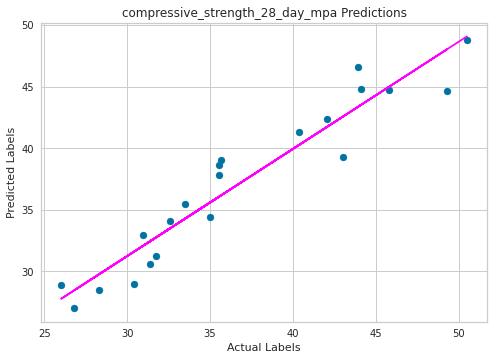

In [260]:
# Use Ridge algorithm
alg = Ridge(max_iter=100000)

# Try these hyperparameter values
alpha_space = np.linspace(0.01, 10, 100)
param_grid = {'alpha':alpha_space}

# Find the best hyperparameter combination to optimize the R2 metric
score = make_scorer(r2_score)
gridsearch = GridSearchCV(alg, 
                          param_grid, 
                          scoring=score, 
                          cv=10, 
                          return_train_score=True)
gridsearch.fit(X_train_scaled, y_train)
print("Best parameter combination:", gridsearch.best_params_, "\n")

# Get the best model
ridge_grid=gridsearch.best_estimator_
print(ridge_grid, "\n")

# Evaluate the model using the test data
y_pred = ridge_grid.predict(X_test_scaled)
y_train_pred = ridge_grid.predict(X_train_scaled)
rgs =train_val(y_train, y_train_pred, y_test, y_pred, "ridge_grid")
print(rgs)

# Plot predicted vs actual
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('compressive_strength_28_day_mpa Predictions')

# Overlay the regression line
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

y_pred = ridge_grid.predict(X_test_scaled)
ridge_grid_R2 = r2_score(y_test, y_pred)
ridge_grid_mae = mean_absolute_error(y_test, y_pred)
ridge_grid_mse = mean_squared_error(y_test, y_pred)
ridge_grid_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

### 8.1.4 Feature Importance

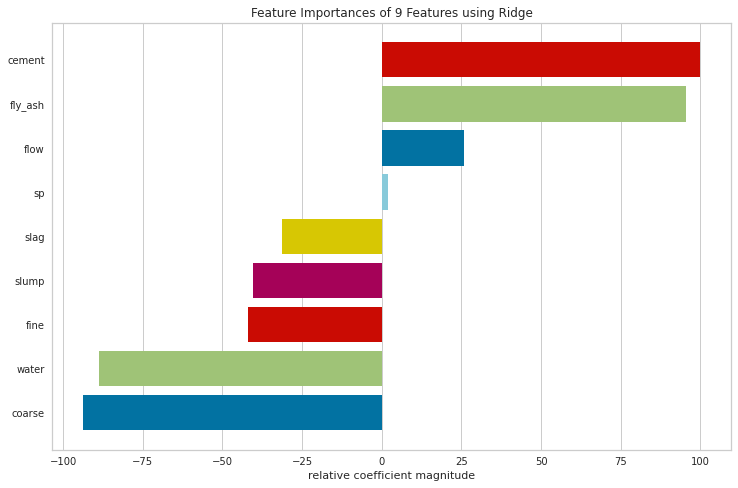

In [261]:
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.features import RadViz

model = Ridge(alpha=0.6154545454545455, max_iter=100000)

viz = FeatureImportances(model, labels=X_train.columns)
visualizer = RadViz(size=(750,500))
viz.fit(X_train_scaled, y_train)
viz.show();

## 8.2 Lasso

**Lasso Regression**, takes the absolute value of the coefficients (|B|) instead of (B2) them, so some attributes are **completely ignored**.

Lasso plays an important role not only in reducing overfit learning, but also in **feature selection**.

### 8.2.1 Lasso Modelling

- Import the modul 
- Do not forget to scale the data or use Normalize parameter as True(If needed)
- Fit the model 
- Predict the test set 
- Evaluate model performance (use performance metrics for regression) 
- Tune alpha hyperparameter by using [cross validation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html) and determine the optimal alpha value.
- Fit the model and predict again with the new alpha value.
- Compare different evaluation metrics

In [262]:
from sklearn.linear_model import Lasso

Lasso() 

      lasso_train  lasso_test
R2          0.773       0.802
mae         3.000       2.460
mse        14.386      10.030
rmse        3.793       3.167


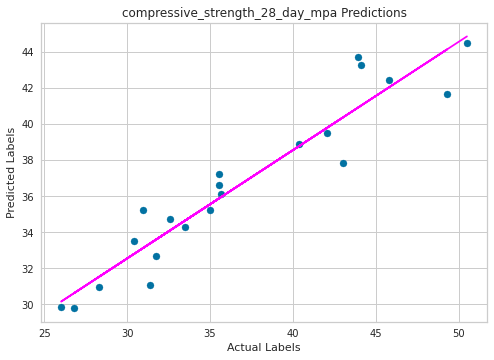

In [263]:
# Fit lasso model on the training set
lasso = Lasso().fit(X_train_scaled, y_train)
print (lasso, "\n")

# Evaluate the model using the test data
y_pred = lasso.predict(X_test_scaled)
y_train_pred = lasso.predict(X_train_scaled)
lss =train_val(y_train, y_train_pred, y_test, y_pred, "lasso")
print(lss)

# Plot predicted vs actual
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('compressive_strength_28_day_mpa Predictions')

# Overlay the regression line
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

y_pred = lasso.predict(X_test_scaled)
lasso_R2 = r2_score(y_test, y_pred)
lasso_mae = mean_absolute_error(y_test, y_pred)
lasso_mse = mean_squared_error(y_test, y_pred)
lasso_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

### 8.2.2 Cross Validation

In [264]:
lasso = Lasso()
scores = cross_validate(lasso, X_train_scaled, y_train, scoring = ['r2', 'neg_mean_absolute_error','neg_mean_squared_error', \
                                                            'neg_root_mean_squared_error'], cv = 10)

scores = pd.DataFrame(scores, index=range(1,11))
scores.iloc[:, 2:].mean()

test_r2                              0.655
test_neg_mean_absolute_error        -3.247
test_neg_mean_squared_error        -17.375
test_neg_root_mean_squared_error    -4.022
dtype: float64

In [265]:
print(lss)

      lasso_train  lasso_test
R2          0.773       0.802
mae         3.000       2.460
mse        14.386      10.030
rmse        3.793       3.167


### 8.2.3 GridSearch

In [266]:
from sklearn.model_selection import GridSearchCV

Best parameter combination: {'alpha': 0.01} 

Lasso(alpha=0.01, max_iter=100000) 

      lasso_grid_train  lasso_grid_test
R2               0.904            0.910
mae              1.960            1.740
mse              6.053            4.578
rmse             2.460            2.140


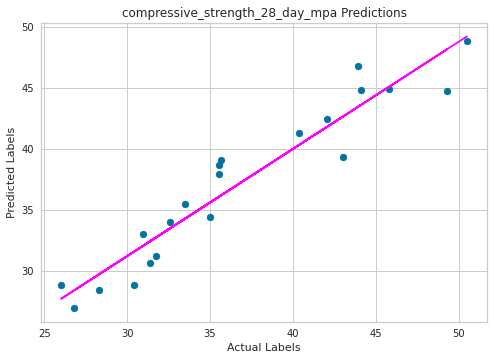

In [267]:
# Use Lasso algorithm
alg = Lasso(max_iter=100000)

# Try these hyperparameter values
alpha_space = np.linspace(0.01, 10, 100)

param_grid = {'alpha':alpha_space}

# Find the best hyperparameter combination to optimize the R2 metric
score = make_scorer(r2_score)
gridsearch = GridSearchCV(alg, 
                          param_grid, 
                          scoring=score, 
                          cv=10, 
                          return_train_score=True)
gridsearch.fit(X_train_scaled, y_train)
print("Best parameter combination:", gridsearch.best_params_, "\n")

# Get the best model
lasso_grid=gridsearch.best_estimator_
print(lasso_grid, "\n")


# Evaluate the model using the test data
y_pred = lasso_grid.predict(X_test_scaled)
y_train_pred = lasso_grid.predict(X_train_scaled)

lsgs =train_val(y_train, y_train_pred, y_test, y_pred, "lasso_grid")
print(lsgs)

# Plot predicted vs actual
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('compressive_strength_28_day_mpa Predictions')

# Overlay the regression line
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

y_pred = lasso_grid.predict(X_test_scaled)
lasso_grid_R2 = r2_score(y_test, y_pred)
lasso_grid_mae = mean_absolute_error(y_test, y_pred)
lasso_grid_mse = mean_squared_error(y_test, y_pred)
lasso_grid_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

### 8.2.4 Feature Importance

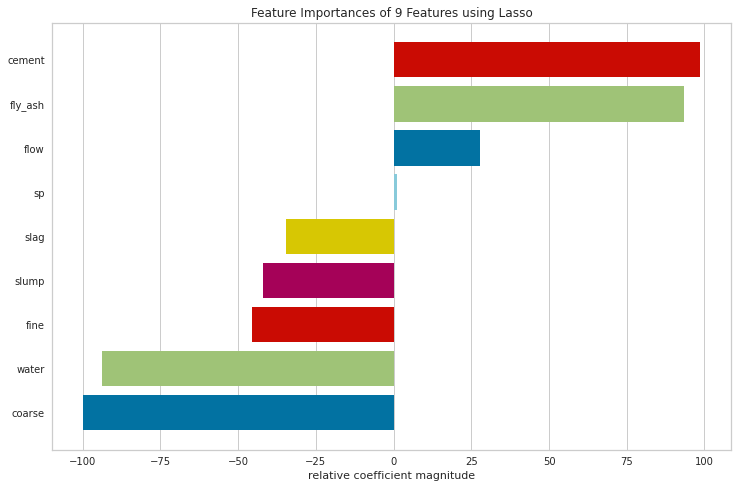

In [268]:
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.features import RadViz

model = Lasso(alpha=0.01, max_iter=100000)

viz = FeatureImportances(model, labels=X_train.columns)
visualizer = RadViz(size=(750,500))
viz.fit(X_train_scaled, y_train)
viz.show();

## 8.3 ElasticNet

**ElasticNet Regularization** term is a straightforward blend of both Ridge and Lasso's regularization terms. But usually the result of its application behaves like LASSO.

### 8.3.1 ElasticNet Modelling

- Import the modul 
- Do not forget to scale the data or use Normalize parameter as True(If needed)
- Fit the model 
- Predict the test set 
- Evaluate model performance (use performance metrics for regression) 
- Tune alpha hyperparameter by using [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) and determine the optimal alpha value.
- Fit the model and predict again with the new alpha value.
- Compare different evaluation metrics

In [269]:
from sklearn.linear_model import ElasticNet

ElasticNet() 

      elastic_train  elastic_test
R2            0.631         0.632
mae           3.837         3.575
mse          23.337        18.624
rmse          4.831         4.316


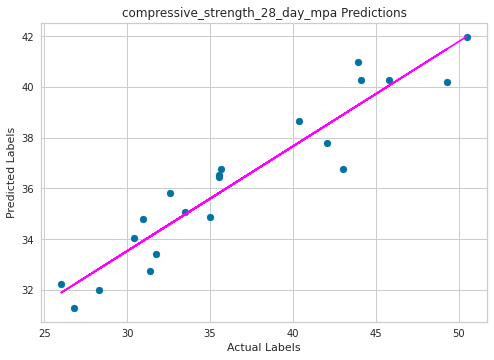

In [270]:
# Fit Elastic model on the training set
elastic = ElasticNet().fit(X_train_scaled, y_train)
print (elastic, "\n")

# Evaluate the model using the test data
y_pred = elastic.predict(X_test_scaled)
y_train_pred = elastic.predict(X_train_scaled)

es =train_val(y_train, y_train_pred, y_test, y_pred, "elastic")
print(es)

# Plot predicted vs actual
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('compressive_strength_28_day_mpa Predictions')

# Overlay the regression line
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

y_pred = elastic.predict(X_test_scaled)
elastic_R2 = r2_score(y_test, y_pred)
elastic_mae = mean_absolute_error(y_test, y_pred)
elastic_mse = mean_squared_error(y_test, y_pred)
elastic_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

### 8.3.2 Cross Validation

In [271]:
elastic = ElasticNet()
scores = cross_validate(elastic, X_train_scaled, y_train, scoring = ['r2', 'neg_mean_absolute_error','neg_mean_squared_error', \
                                                            'neg_root_mean_squared_error'], cv = 10)

scores = pd.DataFrame(scores, index=range(1,11))
scores.iloc[:, 2:].mean()

test_r2                              0.496
test_neg_mean_absolute_error        -4.128
test_neg_mean_squared_error        -27.176
test_neg_root_mean_squared_error    -5.086
dtype: float64

In [272]:
print(es)

      elastic_train  elastic_test
R2            0.631         0.632
mae           3.837         3.575
mse          23.337        18.624
rmse          4.831         4.316


### 8.3.3 GridSearch

Best parameter combination: {'alpha': 0.01, 'l1_ratio': 0.1} 

ElasticNet(alpha=0.01, l1_ratio=0.1, max_iter=100000) 

      elastic_grid_train  elastic_grid_test
R2                 0.904              0.909
mae                1.964              1.749
mse                6.083              4.612
rmse               2.466              2.148


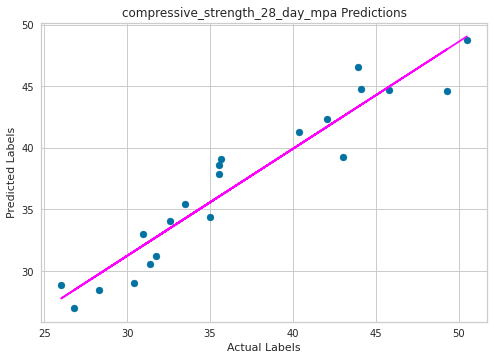

In [273]:
# Use ElasticNet algorithm
alg = ElasticNet(max_iter=100000)

# Try these hyperparameter values
param_grid = {"alpha":[0.01, 0.012, 0.2, 0.5, 0.6, 0.7, 1],
              "l1_ratio":[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]}

# Find the best hyperparameter combination to optimize the R2 metric
score = make_scorer(r2_score)
gridsearch = GridSearchCV(alg, 
                          param_grid, 
                          scoring=score, 
                          cv=10, 
                          return_train_score=True)
gridsearch.fit(X_train_scaled, y_train)
print("Best parameter combination:", gridsearch.best_params_, "\n")

# Get the best model
elastic_grid=gridsearch.best_estimator_
print(elastic_grid, "\n")


# Evaluate the model using the test data
y_pred = elastic_grid.predict(X_test_scaled)
y_train_pred = elastic_grid.predict(X_train_scaled)

egs =train_val(y_train, y_train_pred, y_test, y_pred, "elastic_grid")
print(egs)

# Plot predicted vs actual
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('compressive_strength_28_day_mpa Predictions')

# Overlay the regression line
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

y_pred = elastic_grid.predict(X_test_scaled)
elastic_grid_R2 = r2_score(y_test, y_pred)
elastic_grid_mae = mean_absolute_error(y_test, y_pred)
elastic_grid_mse = mean_squared_error(y_test, y_pred)
elastic_grid_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

### 8.3.4 Feature Importance

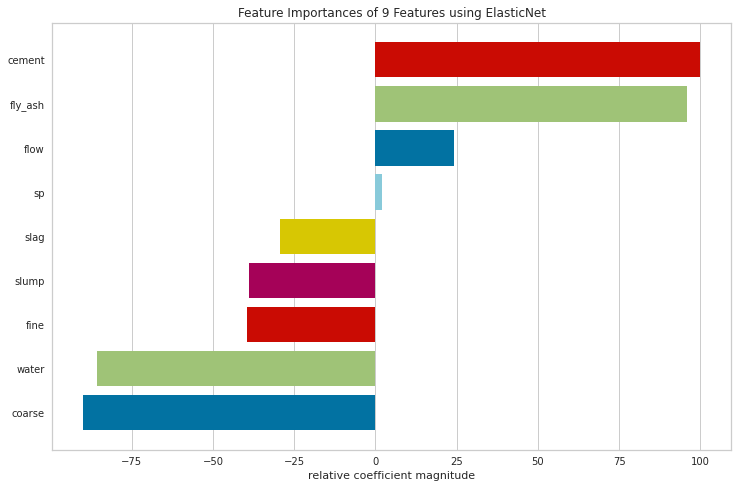

In [274]:
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.features import RadViz

model = ElasticNet(alpha=0.01, l1_ratio=0.1, max_iter=100000)

viz = FeatureImportances(model, labels=X_train.columns)
visualizer = RadViz(size=(750,500))
viz.fit(X_train_scaled, y_train)
viz.show();

# 9. Visually Compare Models Performance In a Graph

In [275]:
pd.concat([ls, rs, rgs, lss, lsgs, es, egs], axis = 1).T.sort_values(by="R2", ascending=False)

,R2,mae,mse,rmse
lasso_grid_test,0.910,1.740,4.578,2.140
ridge_grid_test,0.909,1.749,4.606,2.146
elastic_grid_test,0.909,1.749,4.612,2.148
ridge_test,0.908,1.750,4.630,2.152
linear_test,0.908,1.752,4.640,2.154
linear_train,0.905,1.958,6.029,2.455
lasso_grid_train,0.904,1.960,6.053,2.460
ridge_grid_train,0.904,1.963,6.071,2.464
elastic_grid_train,0.904,1.964,6.083,2.466
ridge_train,0.904,1.964,6.101,2.470


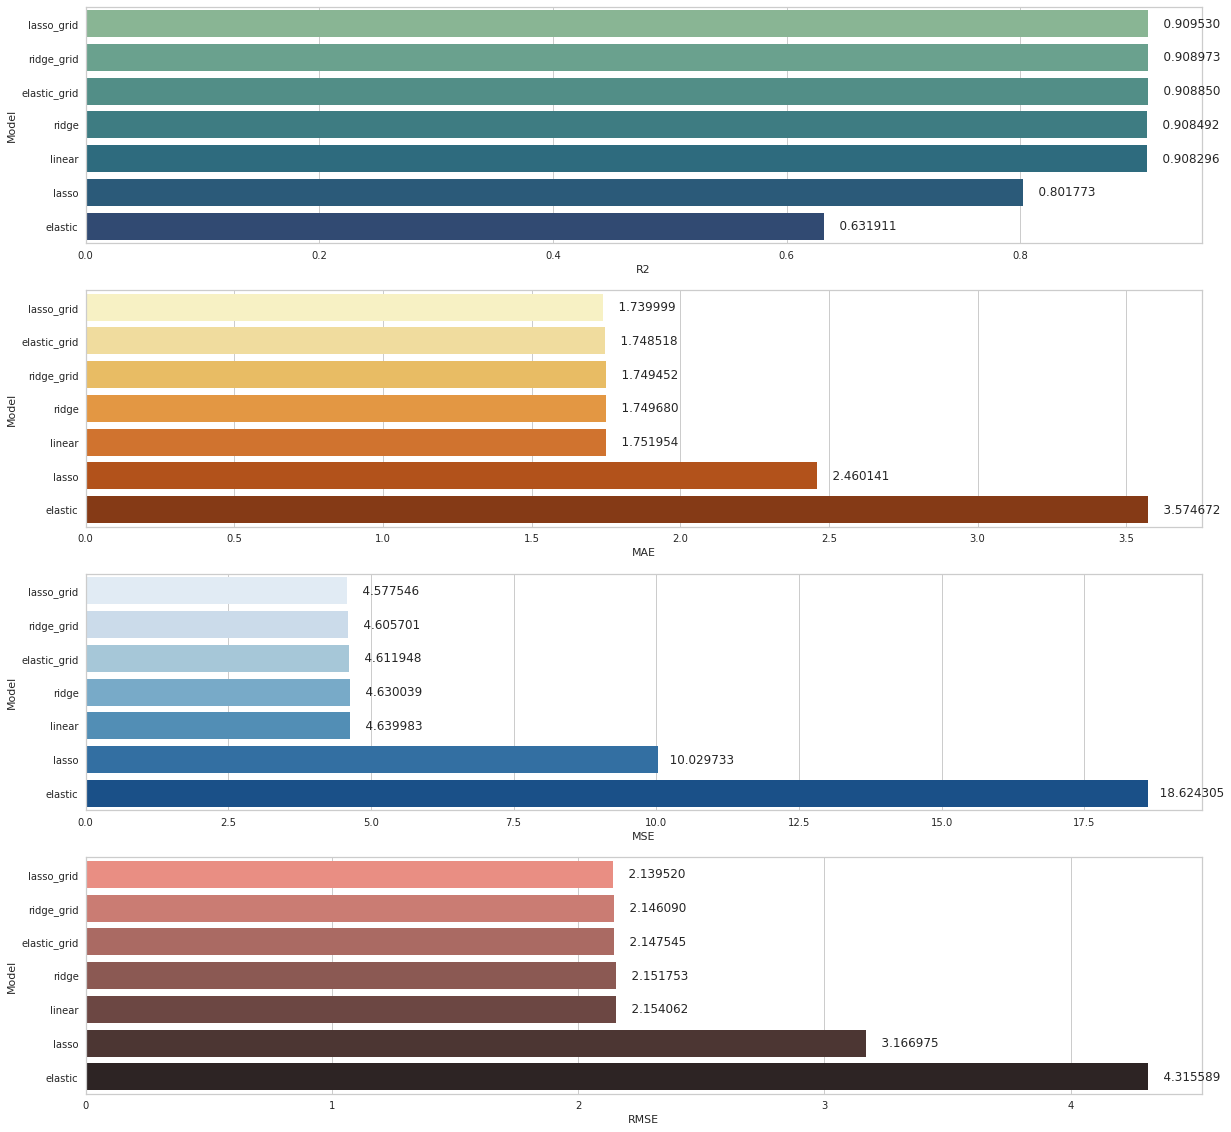

In [276]:
compare = pd.DataFrame({"Model": ["linear", "ridge", "ridge_grid", "lasso", "lasso_grid", "elastic", "elastic_grid"],
            "R2": [linear_R2, ridge_R2, ridge_grid_R2, lasso_R2, lasso_grid_R2, elastic_R2, elastic_grid_R2],
            "MAE": [linear_mae, ridge_mae, ridge_grid_mae, lasso_mae, lasso_grid_mae, elastic_mae, elastic_grid_mae],
            "MSE": [linear_mse, ridge_mse, ridge_grid_mse, lasso_mse, lasso_grid_mse, elastic_mse, elastic_grid_mse],
            "RMSE": [linear_rmse, ridge_rmse, ridge_grid_rmse, lasso_rmse, lasso_grid_rmse, elastic_rmse, elastic_grid_rmse]})

def labels(ax):
    for p in ax.patches:
        width = p.get_width()                        # get bar length
        ax.text(width,                               # set the text at 1 unit right of the bar
                p.get_y() + p.get_height() / 2,      # get Y coordinate + X coordinate / 2
                '{:12f}'.format(width),             # set variable to display, 2 decimals
                ha = 'left',                         # horizontal alignment
                va = 'center')                       # vertical alignment
    
plt.figure(figsize=(20,20))
plt.subplot(411)
compare = compare.sort_values(by="R2", ascending=False)
ax=sns.barplot(x="R2", y="Model", data=compare, palette="crest")
labels(ax)

plt.subplot(412)
compare = compare.sort_values(by="MAE", ascending=True)
ax=sns.barplot(x="MAE", y="Model", data=compare, palette="YlOrBr")
labels(ax)

plt.subplot(413)
compare = compare.sort_values(by="MSE", ascending=True)
ax=sns.barplot(x="MSE", y="Model", data=compare, palette="Blues")
labels(ax)

plt.subplot(414)
compare = compare.sort_values(by="RMSE", ascending=True)
ax=sns.barplot(x="RMSE", y="Model", data=compare, palette="dark:salmon_r")
labels(ax)

plt.show()

# 10. Use the Trained Model for Prediction

Now let's see how we can use a trained model with new data.

In [277]:
import joblib

# Save the model as a pickle file
filename = './concrete_slump_test.pkl'
joblib.dump(Lasso(alpha=0.01, max_iter=100000), filename)

['./concrete_slump_test.pkl']

We can load the saved model at any time and make predictions with the new data.

In [278]:
final_scaler = StandardScaler()
final_scaler.fit(X)
X_scaled = final_scaler.transform(X)


# Load the model from the file
loaded_model = joblib.load(filename)
loaded_model.fit(X_scaled,y)

# Create a numpy array containing a new observation
X_new = pd.DataFrame(np.array([[229.894, 77.974, 149.015, 197.168, 883.979, 739.605, 49.611, 0.000, 0.000]]).astype('float64'))
X_new.columns = X.columns.tolist()
X_new_scaled = final_scaler.transform(X_new)

# Use the model to predict
result = loaded_model.predict(X_new_scaled)
print('Prediction: {:.0f}'.format(np.round(result[0])))

Prediction: 36


In [279]:
df_sample = df.sample(10)
df_sample

,cement,slag,fly_ash,water,coarse,fine,flow,sp,slump,strength
19,296.000,97.000,0.000,219.000,932.000,685.000,48.500,0.390,-0.501,29.230
21,310.000,0.000,143.000,218.000,787.000,804.000,46.000,0.714,-0.742,36.190
32,366.000,0.000,187.000,191.000,824.000,757.000,62.700,-0.444,0.818,52.650
62,299.000,107.000,0.000,210.000,881.000,745.000,63.000,0.714,0.854,28.290
12,142.000,130.000,167.000,215.000,735.000,836.000,67.000,-0.997,0.927,31.370
97,295.300,0.000,239.900,236.200,780.300,722.900,77.000,0.130,0.854,44.080
69,336.000,134.000,0.000,222.000,756.000,787.000,64.000,-0.997,1.001,31.900
27,295.000,106.000,136.000,208.000,871.000,650.000,70.000,-0.997,1.076,39.400
38,158.000,0.000,246.000,174.000,1035.000,706.000,43.000,-0.444,0.014,34.990
66,160.000,0.000,250.000,168.000,1049.000,688.000,48.000,1.242,-0.119,37.660


In [280]:
X_new = df_sample.drop('strength', axis=1)
X_new_scaled = final_scaler.transform(X_new)

# Use the model to predict
results = loaded_model.predict(X_new_scaled)
print('Predictions:')
for prediction in results:
    print(np.round(prediction, 3))

df_sample['prediction'] = results
df_sample

Predictions:
27.393
42.047
51.898
28.584
30.056
44.458
32.336
39.466
36.461
38.63


,cement,slag,fly_ash,water,coarse,fine,flow,sp,slump,strength,prediction
19,296.000,97.000,0.000,219.000,932.000,685.000,48.500,0.390,-0.501,29.230,27.393
21,310.000,0.000,143.000,218.000,787.000,804.000,46.000,0.714,-0.742,36.190,42.047
32,366.000,0.000,187.000,191.000,824.000,757.000,62.700,-0.444,0.818,52.650,51.898
62,299.000,107.000,0.000,210.000,881.000,745.000,63.000,0.714,0.854,28.290,28.584
12,142.000,130.000,167.000,215.000,735.000,836.000,67.000,-0.997,0.927,31.370,30.056
97,295.300,0.000,239.900,236.200,780.300,722.900,77.000,0.130,0.854,44.080,44.458
69,336.000,134.000,0.000,222.000,756.000,787.000,64.000,-0.997,1.001,31.900,32.336
27,295.000,106.000,136.000,208.000,871.000,650.000,70.000,-0.997,1.076,39.400,39.466
38,158.000,0.000,246.000,174.000,1035.000,706.000,43.000,-0.444,0.014,34.990,36.461
66,160.000,0.000,250.000,168.000,1049.000,688.000,48.000,1.242,-0.119,37.660,38.630


    Actual   Pred  Residual
19  29.230 27.393     1.837
21  36.190 42.047    -5.857
32  52.650 51.898     0.752
62  28.290 28.584    -0.294
12  31.370 30.056     1.314
97  44.080 44.458    -0.378
69  31.900 32.336    -0.436
27  39.400 39.466    -0.066
38  34.990 36.461    -1.471
66  37.660 38.630    -0.970


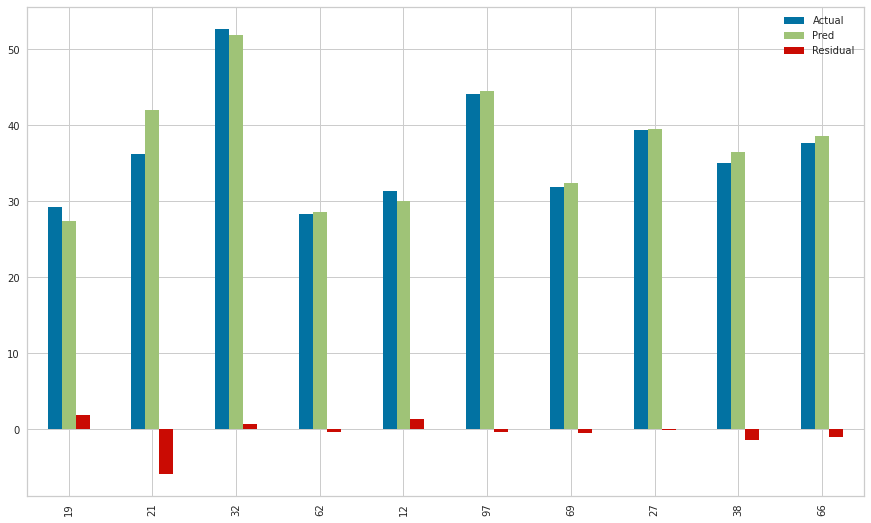

In [281]:
my_dict = {'Actual': df_sample['strength'], 'Pred': df_sample['prediction'],\
           'Residual': df_sample['strength']-df_sample['prediction']}
compare = pd.DataFrame(my_dict)

print(compare)

compare.plot(kind='bar',figsize=(15,9))
plt.show()

# 11. Conclusion

If we briefly summarize what we have done so far;

- First of all, we tried to understand our dataset to get an overview,

- After getting an overview and understand the variables, keep on getting basic information from dataframe,

- According to the results of the basic information from the data set, we performed different operations and made some necessary adjusment on some columns, 

- We visualized the variables to analyze relationships between variables,

- And then we implemented a few pre-processing before moving to modelling,

- After that we implemented Linear Regression, Ridge Regression, Lasso Regression,and Elastic-Net algorithms,

- Chose final model and deployed it,

- And finally made prediction with final model.

We have come to the end of the study. I hope it was useful. I would be very happy if you send your constructive and educational comments about the kernel. 

**Please don't forget to upvote if you liked!**